In [1]:
import h5py
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb
from scipy.optimize import curve_fit
from scipy.special import erfc
import os

def gauss(x, H, A, x0, sigma): 
    return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))

s6range = [2.4795, 2.4850] # Range to fit peak to for S6+
s4range = [2.4765, 2.4800] # Range to fit peak to for S2-
s2range = [2.469, 2.472] # Range to fit peak to for S2-
s1range = [2.472, 2.475] # Range to fit peak to for S2-

data = pd.read_csv('S_XANES_all_norm.csv')
energy = pd.to_numeric(data.columns, errors='coerce')[13:]

# Find the index for which to filter the S6+ peak
s6_range_min = np.argmin(np.absolute(energy - s6range[0]))
s6_range_max = np.argmin(np.absolute(energy - s6range[1]))
s6_x = energy[s6_range_min:s6_range_max]
s6mean = (s6range[1]-s6range[0])+s6range[0]
print(s6mean)
s6sigma = 0.01

# Find the index for which to filter the S4+ peak
s4_range_min = np.argmin(np.absolute(energy - s4range[0]))
s4_range_max = np.argmin(np.absolute(energy - s4range[1]))
s4_x = energy[s4_range_min:s4_range_max]
s4mean = (s4range[1]-s4range[0])+s4range[0]
s4sigma = 0.01

# Find the index for which to filter the S2- peak
s2_range_min = np.argmin(np.absolute(energy - s2range[0]))
s2_range_max = np.argmin(np.absolute(energy - s2range[1]))
s2_x = energy[s2_range_min:s2_range_max]
s2mean = (s2range[1]-s2range[0])+s2range[0]
s2sigma = 0.01

# Find the index for which to filter the S2- peak
s1_range_min = np.argmin(np.absolute(energy - s1range[0]))
s1_range_max = np.argmin(np.absolute(energy - s1range[1]))
s1_x = energy[s1_range_min:s1_range_max]
s1mean = (s1range[1]-s1range[0])+s1range[0]
s1sigma = 0.01

2.485


2.4822499999999996


/var/folders/pf/__j8h2d157772zgzy8kkpjr80000gp/T/ipykernel_2169/1936707934.py:116: OptimizeWarning: Covariance of the parameters could not be estimated
  popt,pcov = curve_fit(gaus,s4_x,y,p0=[1,s4mean,s4sigma]) # fit a gaussian curve


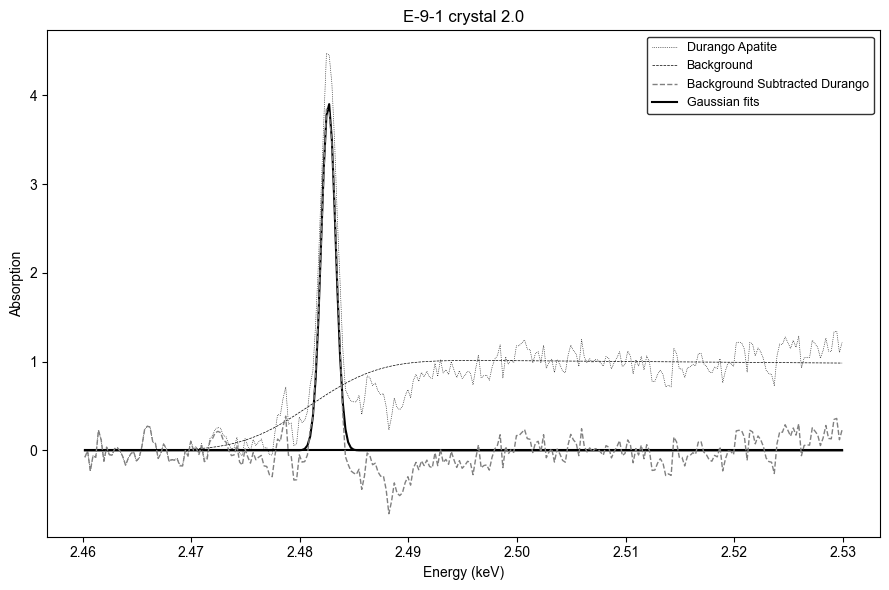

1.0000000002307887


In [145]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erfc

# EMG function with fixed mu
def emg_unit(x, mu, sigma, lam):
    """Normalized EMG with asymptote from 0 to 1"""
    part1 = (lam / 2) * np.exp((lam / 2) * (2 * mu + lam * sigma**2 - 2 * x))
    part2 = erfc((mu + lam * sigma**2 - x) / (np.sqrt(2) * sigma))
    emg_raw = part1 * part2
    emg_min = np.min(emg_raw)
    emg_max = np.max(emg_raw)
    return (emg_raw - emg_min) / (emg_max - emg_min)

def emg_scaled(x, sigma, lam, A, baseline):
    return A * emg_unit(x, mu_fixed, sigma, lam) + baseline


# --- Load data ---
data = pd.read_csv('S_XANES_all_norm.csv')
energy = pd.to_numeric(data.columns, errors='coerce')[13:]
data = data[data['Discard'] != 'x'].reset_index(drop=True)
sample_groups = [data.groupby('Sample').get_group(x) for x in data.groupby('Sample').groups]
sample = sample_groups[8] 
crystal_groups = [sample.groupby('Crystal').get_group(x) for x in sample.groupby('Crystal').groups]
crystal = crystal_groups[0] # Pick individual crystal to be averaged

info = crystal.iloc[:, 0:-282]
sample_name = crystal['Sample'].iloc[0]
crystal_name = crystal['Crystal'].iloc[0]
crystal = crystal.iloc[:, -280:]
average = np.mean(crystal, axis = 0)

# --- Fit background ---
# NOTE: energy in keV, so we fix mu accordingly
mu_fixed = 2.481 # inflection point in keV

# Select pre-edge and post-edge regions
pre_edge = (energy < 2.468)
post_edge = (energy > 2.49)  # slightly increased range

pre_edge_mean = np.mean(average[pre_edge])
post_edge_mean = np.mean(average[post_edge])

average = (average - pre_edge_mean) / (post_edge_mean - pre_edge_mean)

background_x = np.concatenate((energy[pre_edge], energy[post_edge]))
background_y = np.concatenate((average[pre_edge], average[post_edge]))

p0 = [0.0003, 1, max(background_y), min(background_y)]  # smaller sigma, bigger lam
bounds = ([1e-6, 0.9, 0, -np.inf], [0.005, 1.1, np.inf, np.inf])
        


# Fit
popt, _ = curve_fit(emg_scaled, background_x, background_y, p0=p0, bounds=bounds, maxfev=10000)

# Evaluate EMG background over full energy range
emg_fit_full = emg_scaled(energy, *popt)

# Optional normalization: force background to 0 at pre-edge, 1 at post-edge
emg_pre = np.mean(emg_fit_full[pre_edge])
emg_post = np.mean(emg_fit_full[post_edge])
emg_fit_norm = (emg_fit_full - emg_pre) / (emg_post - emg_pre)

# Subtract background
y_corrected = average - emg_fit_norm

# --- Plot ---
plt.figure(figsize=(9,6))
plt.plot(energy, average, label='Durango Apatite', color = 'black', linestyle = 'dotted', linewidth = 0.5)
plt.plot(energy, emg_fit_norm, color = 'black', linestyle = '--', label='Background', linewidth = 0.5)
plt.plot(energy, y_corrected, color = 'gray', linestyle = 'dashed', label='Background Subtracted Durango', linewidth = 1)

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


s4range = [2.4765, 2.4800]
s6range = [2.4795, 2.4850]
ionrange = [2.485, 2.487] # Range to fit peak to for S2-



# Find the index for which to filter the S6+ peak
s6_range_min = np.argmin(np.absolute(energy - s6range[0]))
s6_range_max = np.argmin(np.absolute(energy - s6range[1]))
s6_x = energy[s6_range_min:s6_range_max]
s6mean = np.mean(s6range)
print(s6mean)
s6sigma = 0.01

# Find the index for which to filter the S4+ peak
s4_range_min = np.argmin(np.absolute(energy - s4range[0]))
s4_range_max = np.argmin(np.absolute(energy - s4range[1]))
s4_x = energy[s4_range_min:s4_range_max]
s4mean = np.mean(s4range)

s4sigma = 0.01


# Find the index for which to filter the ionisation peak
ion_range_min = np.argmin(np.absolute(energy - ionrange[0]))
ion_range_max = np.argmin(np.absolute(energy - ionrange[1]))
ion_x = energy[ion_range_min:ion_range_max]
ionmean = (ionrange[1]-ionrange[0])+s4range[0]
ionsigma = 0.01

peak_dict = {}
total_peak_area = 0


y = y_corrected[s4_range_min:s4_range_max].values # interval for s6 to fit to
popt,pcov = curve_fit(gaus,s4_x,y,p0=[1,s4mean,s4sigma]) # fit a gaussian curve
s4curve = gaus(energy,*popt) # save fitted peak
peak_dict['S4+'] = s4curve
s4area = np.trapz(gaus(energy, *popt), energy) # Calculate peak area ratio
total_peak_area = total_peak_area + s4area 

# y = y_corrected[ion_range_min:ion_range_max].values # interval for s6 to fit to
# popt,pcov = curve_fit(gaus,ion_x,y,p0=[1,ionmean,ionsigma]) # fit a gaussian curve
# ioncurve = gaus(energy,*popt)
# peak_dict['ion'] = ioncurve
# ionarea = np.trapz(energy,gaus(energy,*popt))
# total_peak_area = total_peak_area + ionarea

y = y_corrected[s6_range_min:s6_range_max].values # interval for s6 to fit to
popt,pcov = curve_fit(gaus,s6_x,y,p0=[1,s6mean,s6sigma]) # fit a gaussian curve
s6curve = gaus(energy,*popt)
peak_dict['S6+'] = s6curve
s6area = np.trapz(gaus(energy, *popt), energy)
total_peak_area = total_peak_area + s6area
peakratio = s6area/total_peak_area


# plt.plot(energy, y_corrected, label='Background Subtracted Spectrum')

plt.plot(energy,s4curve, color = 'black', label = 'Gaussian fits', zorder = 0.1)
plt.plot(energy,s6curve, color = 'black', zorder = 0.1)
# plt.plot(energy,ioncurve)


plt.title(sample_name + ' crystal ' + str(crystal_name))
plt.legend(edgecolor = 'black', fontsize = 9)
plt.xlabel('Energy (keV)')
plt.ylabel('Absorption')
# plt.grid(True)
plt.tight_layout()
plt.show()

print(peakratio)

2.4822499999999996


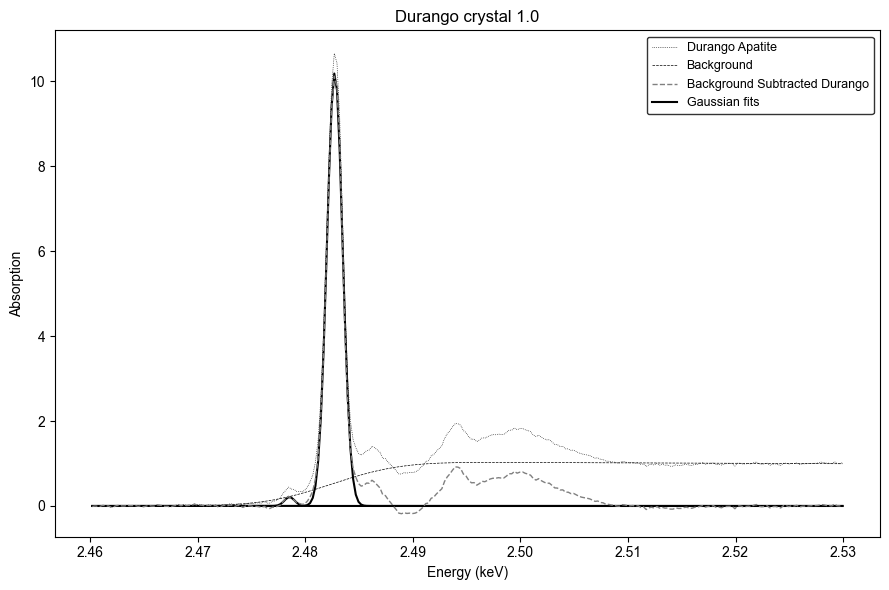

0.9866526368295055


In [133]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erfc

# EMG function with fixed mu
def emg_unit(x, mu, sigma, lam):
    """Normalized EMG with asymptote from 0 to 1"""
    part1 = (lam / 2) * np.exp((lam / 2) * (2 * mu + lam * sigma**2 - 2 * x))
    part2 = erfc((mu + lam * sigma**2 - x) / (np.sqrt(2) * sigma))
    emg_raw = part1 * part2
    emg_min = np.min(emg_raw)
    emg_max = np.max(emg_raw)
    return (emg_raw - emg_min) / (emg_max - emg_min)

def emg_scaled(x, sigma, lam, A, baseline):
    return A * emg_unit(x, mu_fixed, sigma, lam) + baseline


# --- Load data ---
data = pd.read_csv('S_XANES_all_norm.csv')
energy = pd.to_numeric(data.columns, errors='coerce')[13:]
data = data[data['Discard'] != 'x'].reset_index(drop=True)
sample_groups = [data.groupby('Sample').get_group(x) for x in data.groupby('Sample').groups]
sample = sample_groups[0] 
crystal_groups = [sample.groupby('Crystal').get_group(x) for x in sample.groupby('Crystal').groups]
crystal = crystal_groups[0] # Pick individual crystal to be averaged

info = crystal.iloc[:, 0:-282]
sample_name = crystal['Sample'].iloc[0]
crystal_name = crystal['Crystal'].iloc[0]
crystal = crystal.iloc[:, -280:]
average = np.mean(crystal, axis = 0)

# --- Fit background ---
# NOTE: energy in keV, so we fix mu accordingly
mu_fixed = 2.4825# inflection point in keV

# Select pre-edge and post-edge regions
pre_edge = (energy < 2.468)
post_edge = (energy > 2.52)  # slightly increased range

pre_edge_mean = np.mean(average[pre_edge])
post_edge_mean = np.mean(average[post_edge])

average = (average - pre_edge_mean) / (post_edge_mean - pre_edge_mean)

background_x = np.concatenate((energy[pre_edge], energy[post_edge]))
background_y = np.concatenate((average[pre_edge], average[post_edge]))

# p0 = [0.0003, 20, max(background_y), min(background_y)]  # smaller sigma, bigger lam
p0 = [0.0003, 5, 1, 0]  # smaller sigma, bigger lam
bounds = ([1e-6, 1, 0, -np.inf], [0.005, 10, np.inf, np.inf])

# Fit
popt, _ = curve_fit(emg_scaled, background_x, background_y, p0=p0, bounds=bounds, maxfev=10000)

# Evaluate EMG background over full energy range
emg_fit_full = emg_scaled(energy, *popt)

# Optional normalization: force background to 0 at pre-edge, 1 at post-edge
emg_pre = np.mean(emg_fit_full[pre_edge])
emg_post = np.mean(emg_fit_full[post_edge])
emg_fit_norm = (emg_fit_full - emg_pre) / (emg_post - emg_pre)

# Subtract background
y_corrected = average - emg_fit_norm

# --- Plot ---
plt.figure(figsize=(9,6))
plt.plot(energy, average, label='Durango Apatite', color = 'black', linestyle = 'dotted', linewidth = 0.5)
plt.plot(energy, emg_fit_norm, color = 'black', linestyle = '--', label='Background', linewidth = 0.5)
plt.plot(energy, y_corrected, color = 'gray', linestyle = 'dashed', label='Background Subtracted Durango', linewidth = 1)

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


s4range = [2.4765, 2.4800]
s6range = [2.4795, 2.4850]
ionrange = [2.485, 2.487] # Range to fit peak to for S2-



# Find the index for which to filter the S6+ peak
s6_range_min = np.argmin(np.absolute(energy - s6range[0]))
s6_range_max = np.argmin(np.absolute(energy - s6range[1]))
s6_x = energy[s6_range_min:s6_range_max]
s6mean = np.mean(s6range)
print(s6mean)
s6sigma = 0.01

# Find the index for which to filter the S4+ peak
s4_range_min = np.argmin(np.absolute(energy - s4range[0]))
s4_range_max = np.argmin(np.absolute(energy - s4range[1]))
s4_x = energy[s4_range_min:s4_range_max]
s4mean = np.mean(s4range)

s4sigma = 0.01


# Find the index for which to filter the ionisation peak
ion_range_min = np.argmin(np.absolute(energy - ionrange[0]))
ion_range_max = np.argmin(np.absolute(energy - ionrange[1]))
ion_x = energy[ion_range_min:ion_range_max]
ionmean = (ionrange[1]-ionrange[0])+s4range[0]
ionsigma = 0.01

peak_dict = {}
total_peak_area = 0


y = y_corrected[s4_range_min:s4_range_max].values # interval for s6 to fit to
popt,pcov = curve_fit(gaus,s4_x,y,p0=[1,s4mean,s4sigma]) # fit a gaussian curve
s4curve = gaus(energy,*popt) # save fitted peak
peak_dict['S4+'] = s4curve
s4area = np.trapz(gaus(energy, *popt), energy) # Calculate peak area ratio
total_peak_area = total_peak_area + s4area 

# y = y_corrected[ion_range_min:ion_range_max].values # interval for s6 to fit to
# popt,pcov = curve_fit(gaus,ion_x,y,p0=[1,ionmean,ionsigma]) # fit a gaussian curve
# ioncurve = gaus(energy,*popt)
# peak_dict['ion'] = ioncurve
# ionarea = np.trapz(energy,gaus(energy,*popt))
# total_peak_area = total_peak_area + ionarea

y = y_corrected[s6_range_min:s6_range_max].values # interval for s6 to fit to
popt,pcov = curve_fit(gaus,s6_x,y,p0=[1,s6mean,s6sigma]) # fit a gaussian curve
s6curve = gaus(energy,*popt)
peak_dict['S6+'] = s6curve
s6area = np.trapz(gaus(energy, *popt), energy)
total_peak_area = total_peak_area + s6area
peakratio = s6area/total_peak_area


# plt.plot(energy, y_corrected, label='Background Subtracted Spectrum')

plt.plot(energy,s4curve, color = 'black', label = 'Gaussian fits', zorder = 0.1)
plt.plot(energy,s6curve, color = 'black', zorder = 0.1)
# plt.plot(energy,ioncurve)


plt.title(sample_name + ' crystal ' + str(crystal_name))
plt.legend(edgecolor = 'black', fontsize = 9)
plt.xlabel('Energy (keV)')
plt.ylabel('Absorption')
# plt.grid(True)
plt.tight_layout()
plt.show()

print(peakratio)

2.4822499999999996


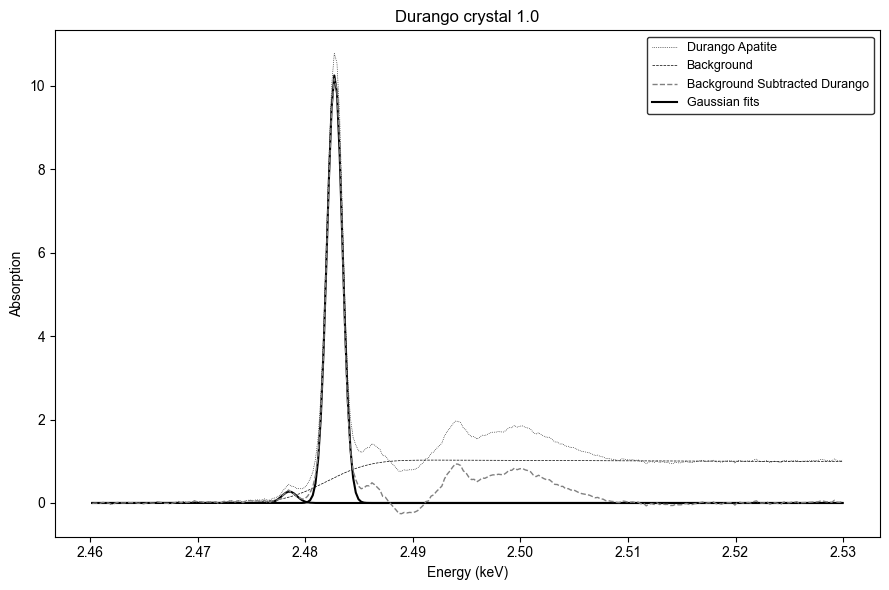

0.9744644499905911


In [109]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erfc

# EMG function with fixed mu
def emg_unit(x, mu, sigma, lam):
    """Normalized EMG with asymptote from 0 to 1"""
    part1 = (lam / 2) * np.exp((lam / 2) * (2 * mu + lam * sigma**2 - 2 * x))
    part2 = erfc((mu + lam * sigma**2 - x) / (np.sqrt(2) * sigma))
    emg_raw = part1 * part2
    emg_min = np.min(emg_raw)
    emg_max = np.max(emg_raw)
    return (emg_raw - emg_min) / (emg_max - emg_min)

def emg_scaled(x, sigma, lam, A, baseline):
    return A * emg_unit(x, mu_fixed, sigma, lam) + baseline


# --- Load data ---
data = pd.read_csv('S_XANES_all_norm.csv')
energy = pd.to_numeric(data.columns, errors='coerce')[13:]
data = data[data['Discard'] != 'x'].reset_index(drop=True)
sample_groups = [data.groupby('Sample').get_group(x) for x in data.groupby('Sample').groups]
sample = sample_groups[0] 
crystal_groups = [sample.groupby('Crystal').get_group(x) for x in sample.groupby('Crystal').groups]
crystal = crystal_groups[0] # Pick individual crystal to be averaged

info = crystal.iloc[:, 0:-282]
sample_name = crystal['Sample'].iloc[0]
crystal_name = crystal['Crystal'].iloc[0]
crystal = crystal.iloc[:, -280:]
average = np.mean(crystal, axis = 0)

# --- Fit background ---
# NOTE: energy in keV, so we fix mu accordingly
mu_fixed = 2.482 # inflection point in keV

# Select pre-edge and post-edge regions
pre_edge = (energy < 2.468)
post_edge = (energy > 2.51)  # slightly increased range

pre_edge_mean = np.mean(average[pre_edge])
post_edge_mean = np.mean(average[post_edge])

average = (average - pre_edge_mean) / (post_edge_mean - pre_edge_mean)

background_x = np.concatenate((energy[pre_edge], energy[post_edge]))
background_y = np.concatenate((average[pre_edge], average[post_edge]))

# p0 = [0.0003, 20, max(background_y), min(background_y)]  # smaller sigma, bigger lam
p0 = [0.001, 5, 1, 0]  # smaller sigma, bigger lam
bounds = ([0.0001, 1, 0, -np.inf], [0.005, 10, np.inf, np.inf])

# Fit
popt, _ = curve_fit(emg_scaled, background_x, background_y, p0=p0, bounds=bounds, maxfev=10000)

# Evaluate EMG background over full energy range
emg_fit_full = emg_scaled(energy, *popt)

# Optional normalization: force background to 0 at pre-edge, 1 at post-edge
emg_pre = np.mean(emg_fit_full[pre_edge])
emg_post = np.mean(emg_fit_full[post_edge])
emg_fit_norm = (emg_fit_full - emg_pre) / (emg_post - emg_pre)

# Subtract background
y_corrected = average - emg_fit_norm

# --- Plot ---
plt.figure(figsize=(9,6))
plt.plot(energy, average, label='Durango Apatite', color = 'black', linestyle = 'dotted', linewidth = 0.5)
plt.plot(energy, emg_fit_norm, color = 'black', linestyle = '--', label='Background', linewidth = 0.5)
plt.plot(energy, y_corrected, color = 'gray', linestyle = 'dashed', label='Background Subtracted Durango', linewidth = 1)

def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


s4range = [2.4765, 2.4800]
s6range = [2.4795, 2.4850]
ionrange = [2.485, 2.487] # Range to fit peak to for S2-



# Find the index for which to filter the S6+ peak
s6_range_min = np.argmin(np.absolute(energy - s6range[0]))
s6_range_max = np.argmin(np.absolute(energy - s6range[1]))
s6_x = energy[s6_range_min:s6_range_max]
s6mean = np.mean(s6range)
print(s6mean)
s6sigma = 0.01

# Find the index for which to filter the S4+ peak
s4_range_min = np.argmin(np.absolute(energy - s4range[0]))
s4_range_max = np.argmin(np.absolute(energy - s4range[1]))
s4_x = energy[s4_range_min:s4_range_max]
s4mean = np.mean(s4range)

s4sigma = 0.01


# Find the index for which to filter the ionisation peak
ion_range_min = np.argmin(np.absolute(energy - ionrange[0]))
ion_range_max = np.argmin(np.absolute(energy - ionrange[1]))
ion_x = energy[ion_range_min:ion_range_max]
ionmean = (ionrange[1]-ionrange[0])+s4range[0]
ionsigma = 0.01

peak_dict = {}
total_peak_area = 0


y = y_corrected[s4_range_min:s4_range_max].values # interval for s6 to fit to
popt,pcov = curve_fit(gaus,s4_x,y,p0=[1,s4mean,s4sigma]) # fit a gaussian curve
s4curve = gaus(energy,*popt) # save fitted peak
peak_dict['S4+'] = s4curve
s4area = np.trapz(gaus(energy, *popt), energy) # Calculate peak area ratio
total_peak_area = total_peak_area + s4area 

# y = y_corrected[ion_range_min:ion_range_max].values # interval for s6 to fit to
# popt,pcov = curve_fit(gaus,ion_x,y,p0=[1,ionmean,ionsigma]) # fit a gaussian curve
# ioncurve = gaus(energy,*popt)
# peak_dict['ion'] = ioncurve
# ionarea = np.trapz(energy,gaus(energy,*popt))
# total_peak_area = total_peak_area + ionarea

y = y_corrected[s6_range_min:s6_range_max].values # interval for s6 to fit to
popt,pcov = curve_fit(gaus,s6_x,y,p0=[1,s6mean,s6sigma]) # fit a gaussian curve
s6curve = gaus(energy,*popt)
peak_dict['S6+'] = s6curve
s6area = np.trapz(gaus(energy, *popt), energy)
total_peak_area = total_peak_area + s6area
peakratio = s6area/total_peak_area


# plt.plot(energy, y_corrected, label='Background Subtracted Spectrum')

plt.plot(energy,s4curve, color = 'black', label = 'Gaussian fits', zorder = 0.1)
plt.plot(energy,s6curve, color = 'black', zorder = 0.1)
# plt.plot(energy,ioncurve)


plt.title(sample_name + ' crystal ' + str(crystal_name))
plt.legend(edgecolor = 'black', fontsize = 9)
plt.xlabel('Energy (keV)')
plt.ylabel('Absorption')
# plt.grid(True)
plt.tight_layout()
plt.show()

print(peakratio)

In [28]:
energy

Index([2.460195, 2.460445, 2.460695, 2.460945, 2.461195, 2.461445, 2.461695,
       2.461945, 2.462195, 2.462445,
       ...
       2.527695, 2.527945, 2.528195, 2.528445, 2.528695, 2.528945, 2.529195,
       2.529445, 2.529695, 2.529945],
      dtype='float64', length=280)

2.4827500000000002
0.7584948617944866


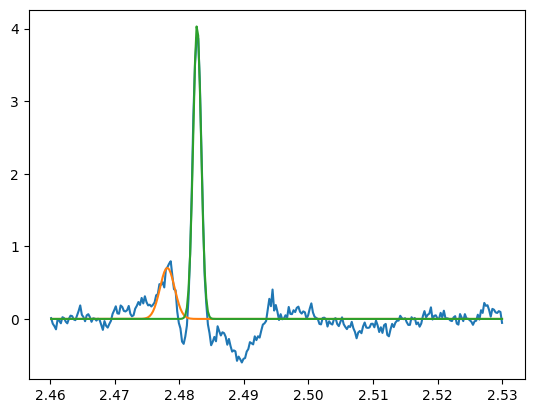

In [350]:
def gaus(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))


s4range = [2.4765, 2.4800]
s6range = [2.4795, 2.4860]
ionrange = [2.485, 2.487] # Range to fit peak to for S2-



# Find the index for which to filter the S6+ peak
s6_range_min = np.argmin(np.absolute(energy - s6range[0]))
s6_range_max = np.argmin(np.absolute(energy - s6range[1]))
s6_x = energy[s6_range_min:s6_range_max]
s6mean = np.mean(s6range)
print(s6mean)
s6sigma = 0.01

# Find the index for which to filter the S4+ peak
s4_range_min = np.argmin(np.absolute(energy - s4range[0]))
s4_range_max = np.argmin(np.absolute(energy - s4range[1]))
s4_x = energy[s4_range_min:s4_range_max]
s4mean = np.mean(s4range)

s4sigma = 0.01


# Find the index for which to filter the ionisation peak
ion_range_min = np.argmin(np.absolute(energy - ionrange[0]))
ion_range_max = np.argmin(np.absolute(energy - ionrange[1]))
ion_x = energy[ion_range_min:ion_range_max]
ionmean = (ionrange[1]-ionrange[0])+s4range[0]
ionsigma = 0.01

peak_dict = {}
total_peak_area = 0


y = y_corrected[s4_range_min:s4_range_max].values # interval for s6 to fit to
popt,pcov = curve_fit(gaus,s4_x,y,p0=[1,s4mean,s4sigma]) # fit a gaussian curve
s4curve = gaus(energy,*popt) # save fitted peak
peak_dict['S4+'] = s4curve
s4area = np.trapz(gaus(energy, *popt), energy) # Calculate peak area ratio
total_peak_area = total_peak_area + s4area 

# y = y_corrected[ion_range_min:ion_range_max].values # interval for s6 to fit to
# popt,pcov = curve_fit(gaus,ion_x,y,p0=[1,ionmean,ionsigma]) # fit a gaussian curve
# ioncurve = gaus(energy,*popt)
# peak_dict['ion'] = ioncurve
# ionarea = np.trapz(energy,gaus(energy,*popt))
# total_peak_area = total_peak_area + ionarea

y = y_corrected[s6_range_min:s6_range_max].values # interval for s6 to fit to
popt,pcov = curve_fit(gaus,s6_x,y,p0=[1,s6mean,s6sigma]) # fit a gaussian curve
s6curve = gaus(energy,*popt)
peak_dict['S6+'] = s6curve
s6area = np.trapz(gaus(energy, *popt), energy)
total_peak_area = total_peak_area + s6area
peakratio = s6area/total_peak_area


plt.plot(energy, y_corrected, label='Background Subtracted Spectrum')

plt.plot(energy,s4curve)
plt.plot(energy,s6curve)
# plt.plot(energy,ioncurve)

print(peakratio)

In [15]:
background_value

NameError: name 'background_value' is not defined

In [156]:
s6area/(s6area+s4area)

0.9892247012065187

In [160]:
crystal

2.460195  2.460445  2.460695  2.460945  2.461195  2.461445  2.461695  \
170  0.130942  0.111370  0.168890  0.004430  0.093618 -0.093942  0.050730   
171 -0.122005 -0.079523  0.052771 -0.099808 -0.290109 -0.182781 -0.100378   
172  0.140763  0.181333  0.095238  0.238641 -0.063803 -0.032778 -0.083102   
173 -0.094273 -0.144452 -0.358114 -0.240531 -0.148037 -0.092256 -0.092510   
174  0.559077  0.071445  0.285605  0.246105 -0.108348 -0.206931  0.048065   
175  0.688042  0.544487  0.259623  0.567043  0.481058  0.314221  0.304796   
176  0.279277  0.137915  0.543979  0.179458  0.561865  0.214832  0.412002   
177  0.195790  0.159274 -0.048092  0.085779  0.151421 -0.099725 -0.022758   
178  0.068998 -0.107836  0.061525 -0.020365 -0.062309  0.026475 -0.078550   
179 -0.193322  0.020361  0.142424 -0.245477 -0.136530  0.008322 -0.048317   

     2.461945  2.462195  2.462445  ...  2.527695  2.527945  2.528195  \
170  0.096726 -0.290454 -0.188288  ...  1.098237  1.165145  0.971614   
171  0.042111 -0.044821  0.102049  ...  1.698852  1.201217  1.511590   
172  0.058922 -0.039123 -0.156838  ...  1.159909  0.935210  1.233946   
173 -0.337856 -0.069137  0.082865  ...  0.780407  1.013364  0.746291   
174  0.431873 -0.225498  0.165487  ...  0.974246  0.547610  0.852421   
175 -0.073275  0.025372  0.327253  ...  0.866643  1.004363  1.246748   
176  0.319737  0.120309 -0.019898  ...  1.152623  1.030945  1.044532   
177 -0.164839  0.246792  0.221804  ...  0.735260  0.963126  0.723847   
178 -0.056958  0.027609 -0.040858  ...  1.105725  0.875977  0.909689   
179  0.122100  0.323408 -0.026860  ...  0.937923  0.747191  0.475997   

     2.528445  2.528695  2.528945  2.529195  2.529445  2.529695  2.529945  
170  0.965583  1.020388  0.897293  0.908133  0.744814  0.716912  0.709064  
171  1.541256  1.206159  1.604799  1.318866  1.181679  1.279262  1.183888  
172  1.037299  0.955410  0.934784  1.285915  0.898781  1.073242  1.360369  
173  1.201160  0.951092  0.771307  1.092430  0.762915  0.870421  0.765171  
174  0.989239  0.748021  1.124429  0.974867  1.129637  1.099966  0.919441  
175  1.172960  0.938695  1.165923  1.112293  1.020784  1.685757  1.262809  
176  1.051274  1.139661  1.033959  0.990153  1.636546  1.257405  1.044670  
177  0.668378  0.865562  0.693241  1.008673  1.205033  0.843679  0.873858  
178  0.971561  0.907200  0.947498  0.876842  0.931118  0.781769  0.673521  
179  0.926513  0.957959  1.094472  1.158120  1.013858  0.721845  0.739451  

[10 rows x 280 columns]

(0.0, 11.0)

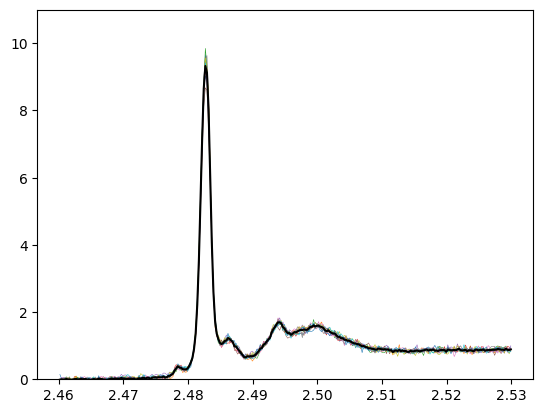

In [28]:
for n, row in crystal.iterrows():
    plt.plot(energy, row, linewidth = 0.4)

plt.plot(energy, np.mean(crystal, axis = 0), label='Original Spectrum', color = 'black')

plt.ylim([0,11])

0.9848571132953993


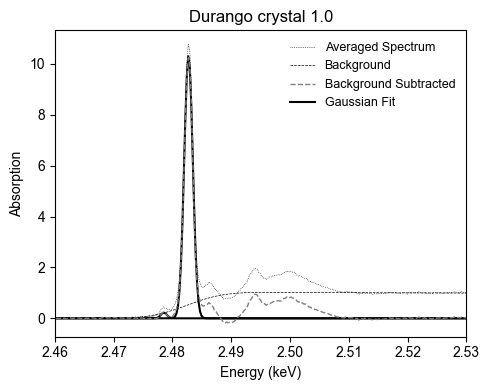

0.9171683816595114


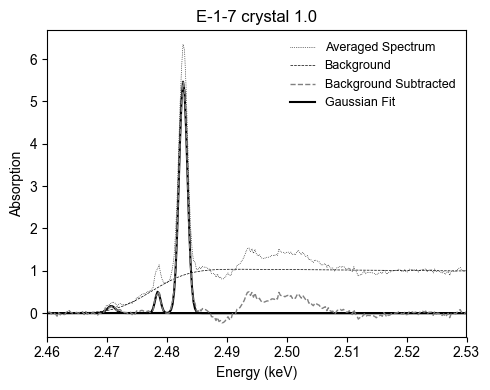

1.0


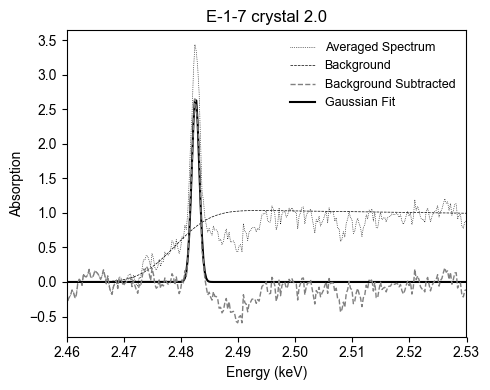

0.9468792930697256


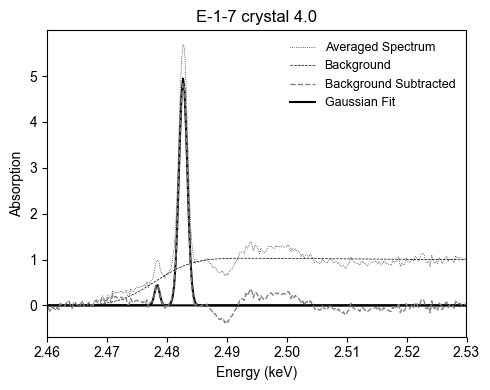

0.9209464889925671


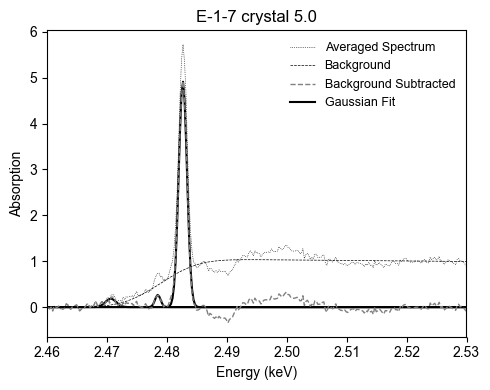

0.9489900165859376


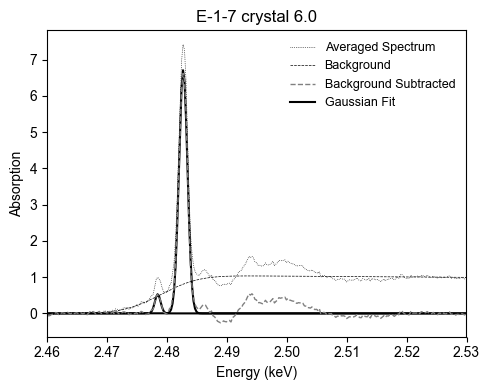

0.9465879414866468


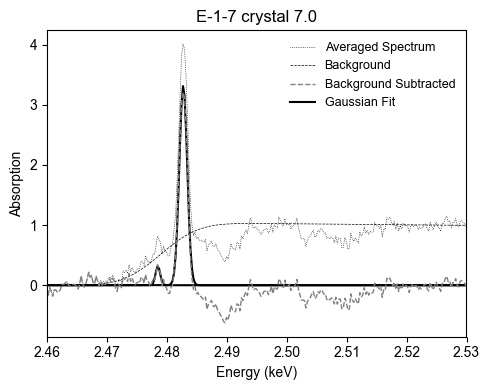

0.8183281979979703


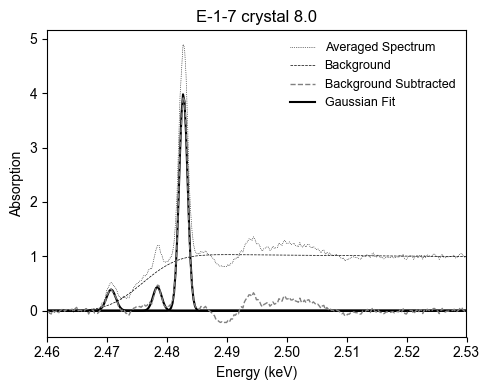

0.930130643360594


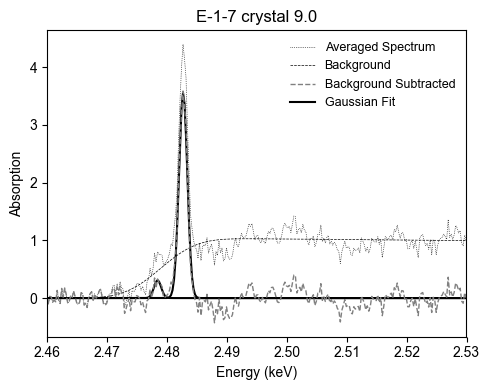

0.9528462240426167


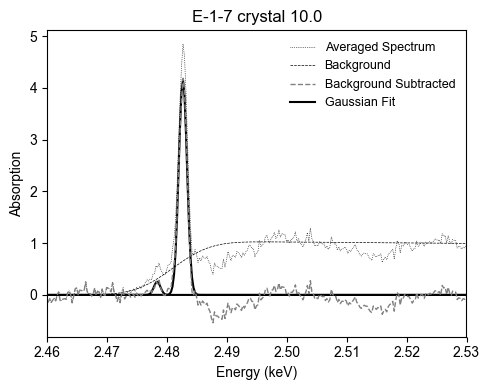

0.9159469297881518


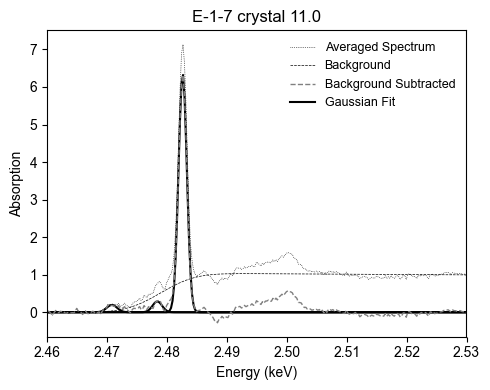

0.8672597872866098


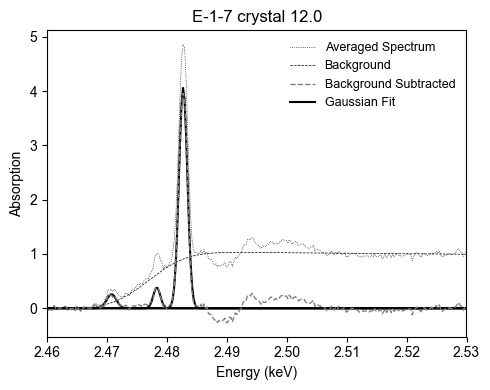

0.9101520543387319


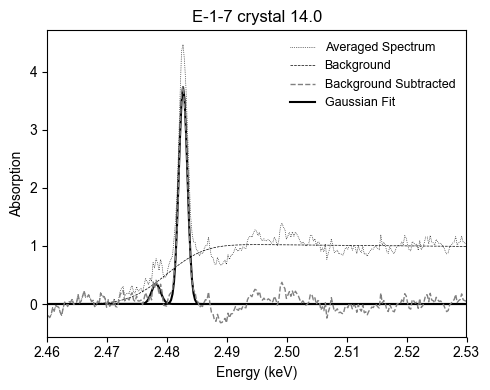

0.8297691428520516


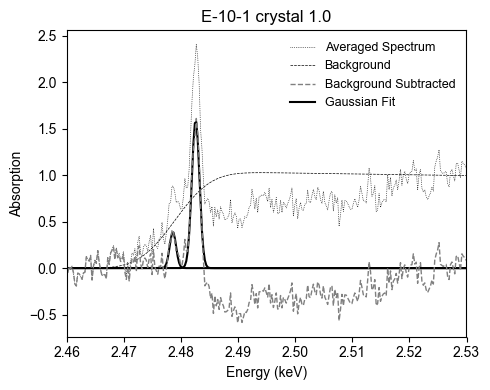

0.8176167471537192


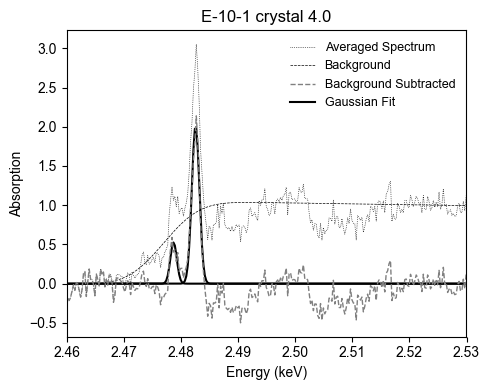

0.8703607977523911


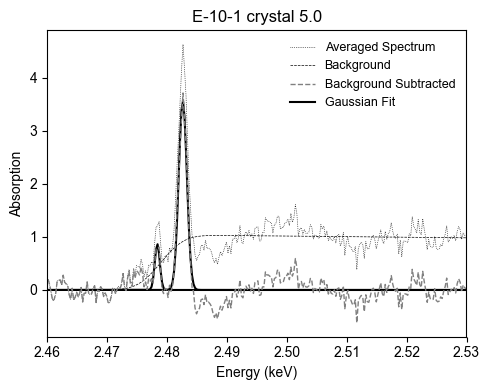

0.8026799616707962


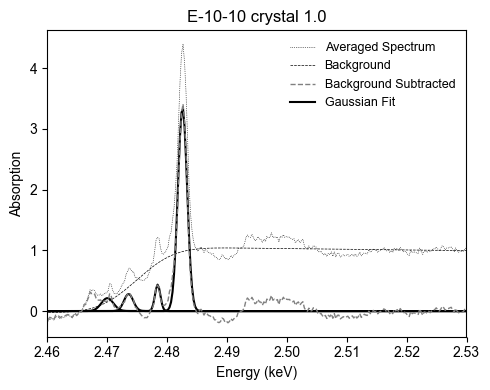

0.90042930679921


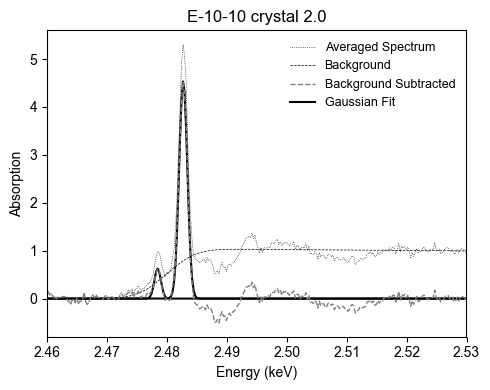

0.9030298812758856


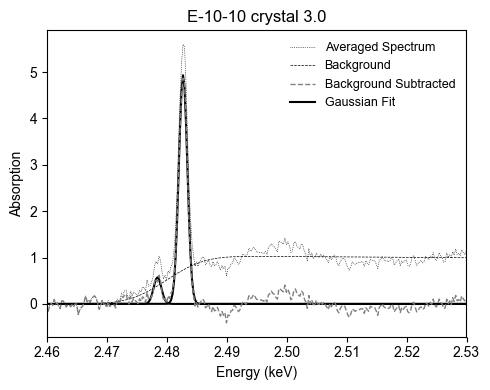

0.9189110772189788


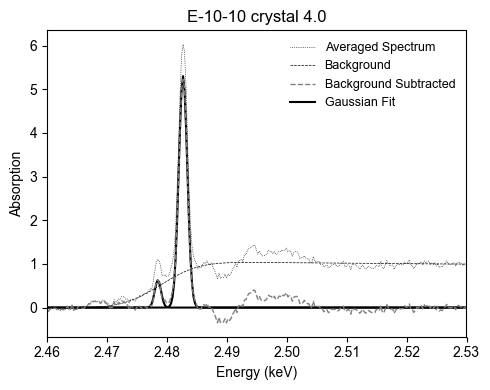

0.9094333030733701


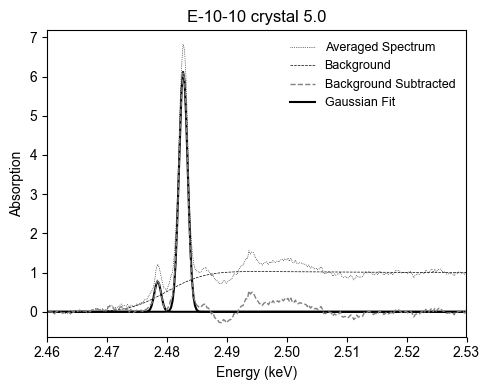

0.9010160375369084


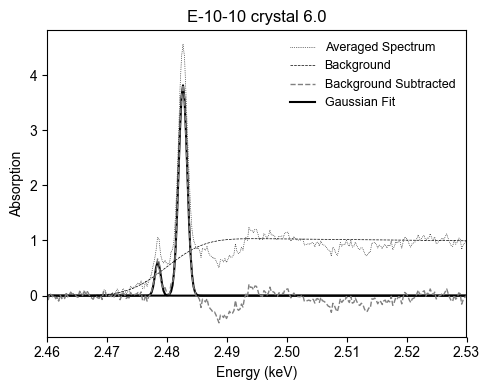

0.9683730520197223


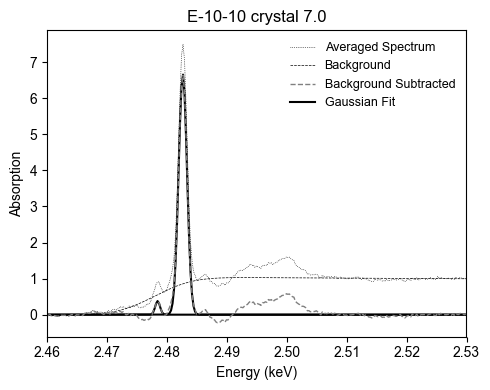

0.9557273482055207


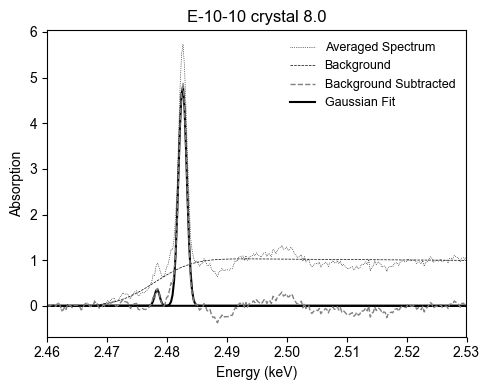

0.9194300648279053


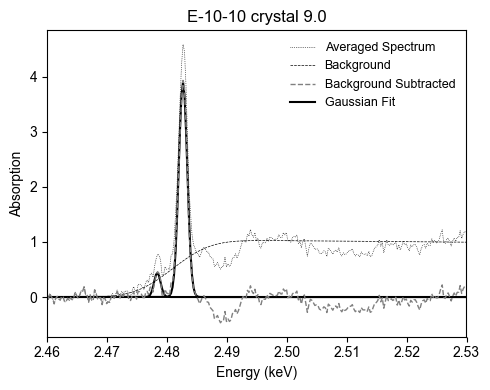

0.8708175201029791


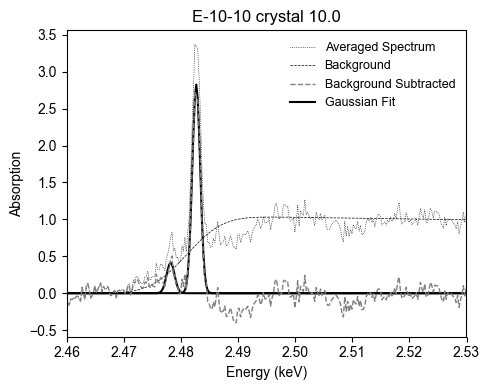

0.8773817626882017


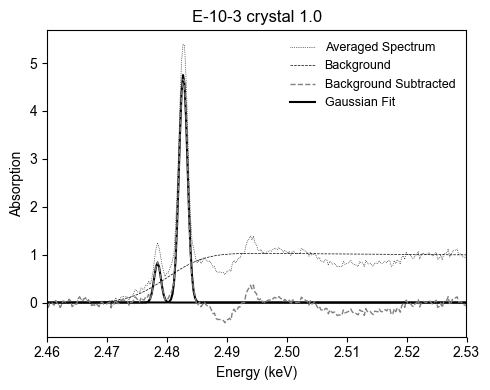

0.8819821236644557


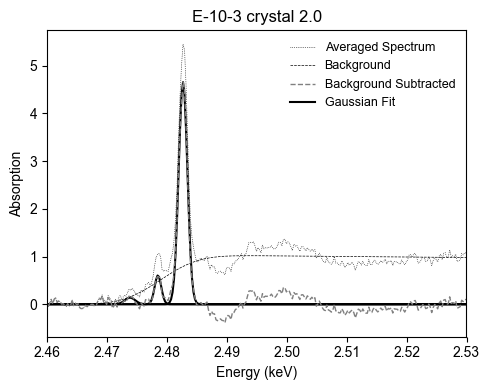

0.8824577712084269


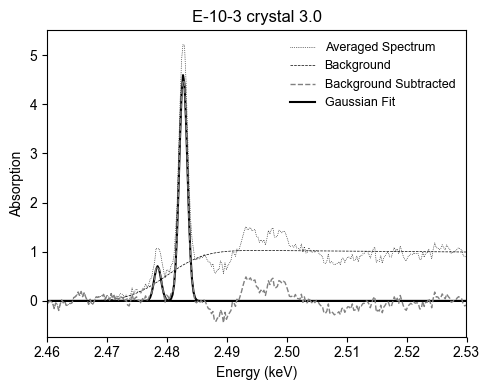

0.9145253563477437


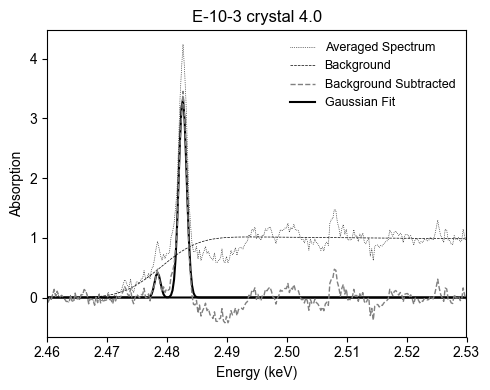

0.885070737656725


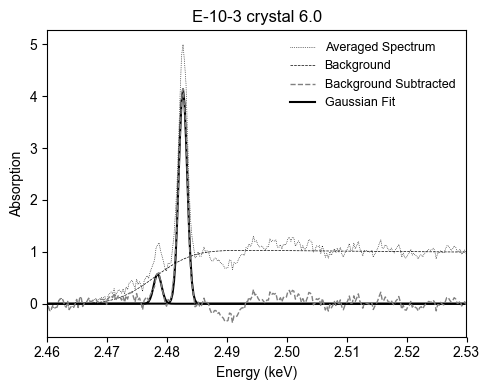

1.0


/var/folders/pf/__j8h2d157772zgzy8kkpjr80000gp/T/ipykernel_2169/1823539909.py:94: OptimizeWarning: Covariance of the parameters could not be estimated
  popt,pcov = curve_fit(gaus,s4_x,y,p0=[1,s4mean,s4sigma]) # fit a gaussian curve


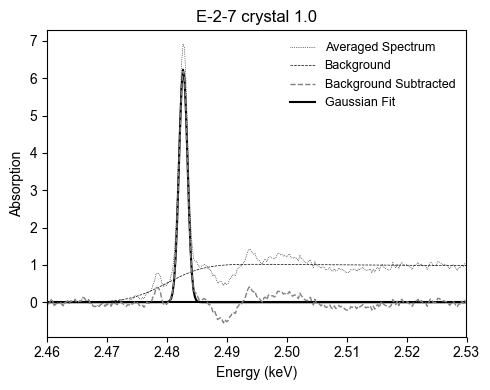

0.9539140503107802


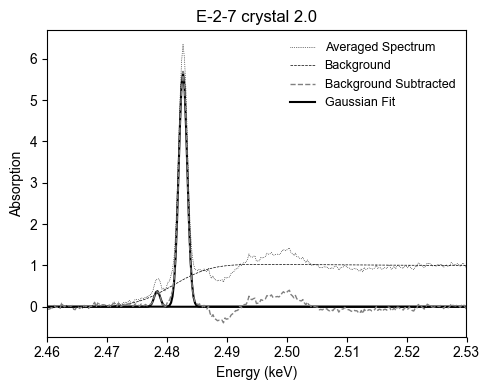

0.953161553376167


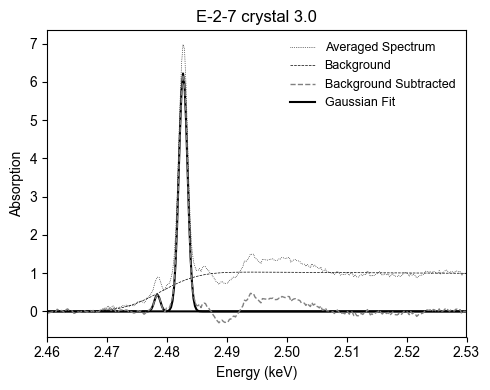

0.9631238103447577


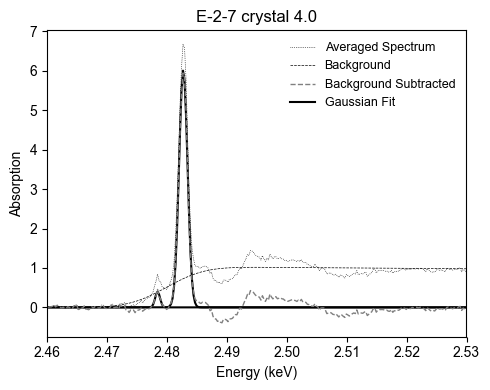

0.942283840433275


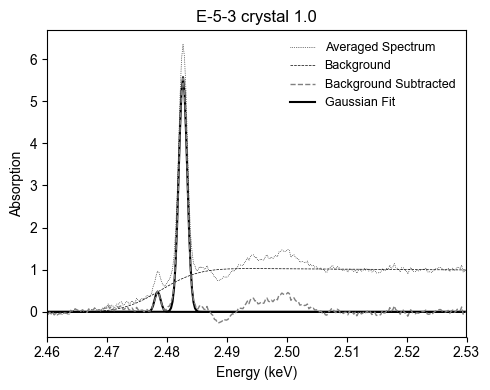

0.8851879548487405


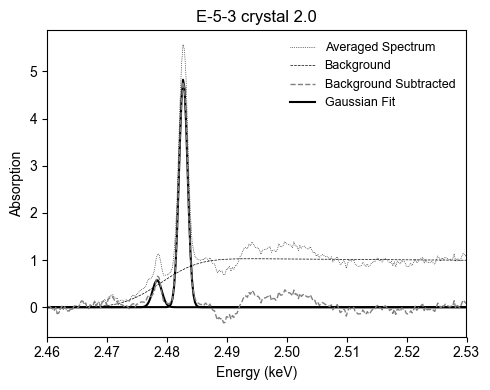

0.9192766718106605


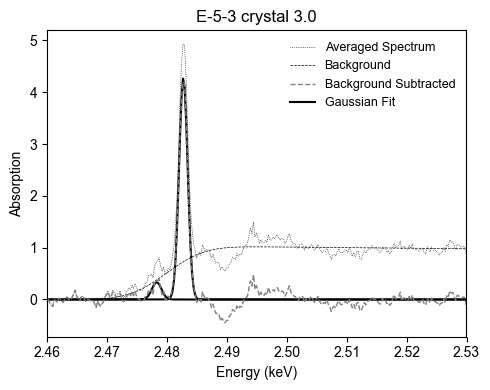

0.9067353319289432


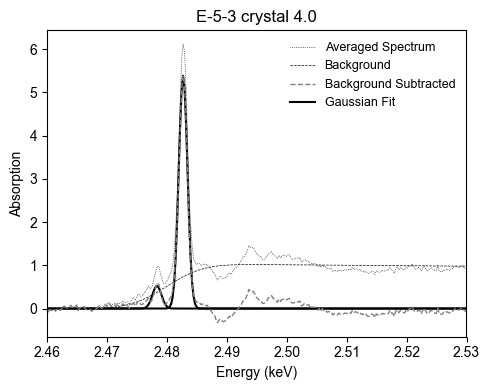

0.8944463238800926


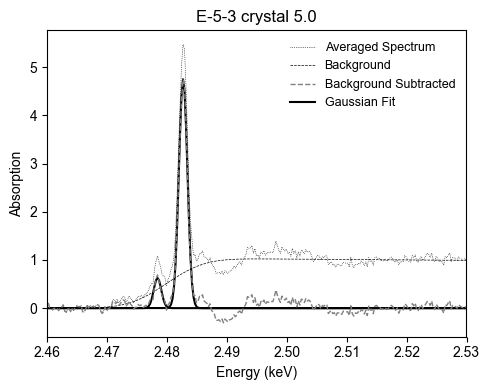

0.9054734512866734


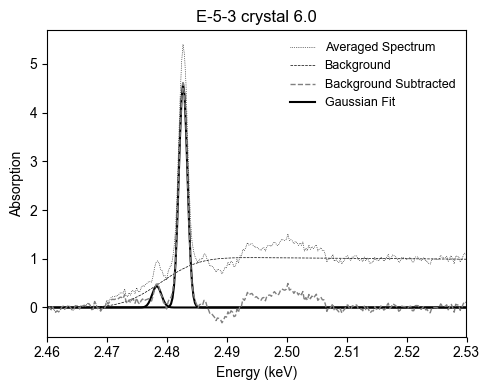

0.9481454244088743


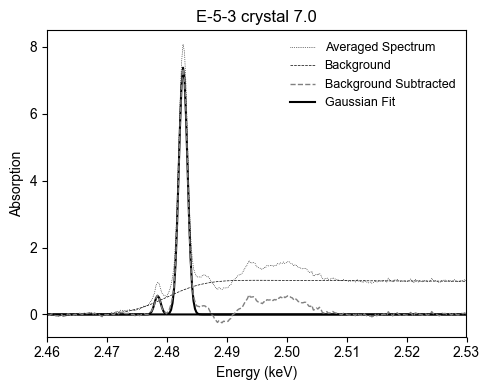

0.9210741600050231


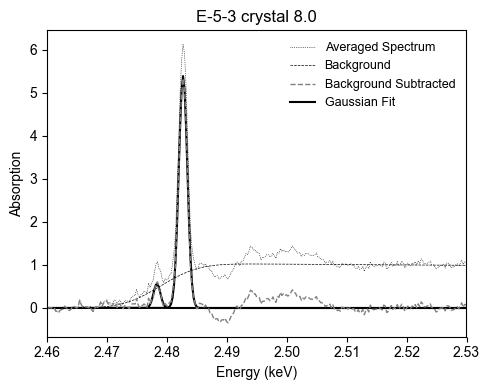

0.9427964941322247


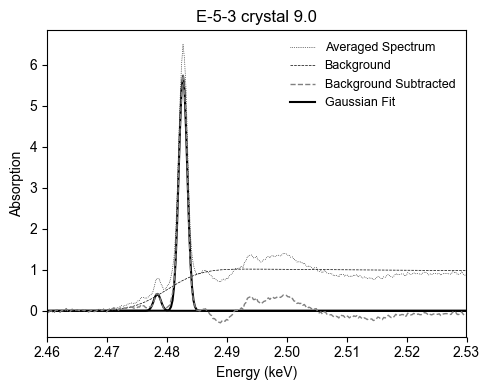

0.9429489857245352


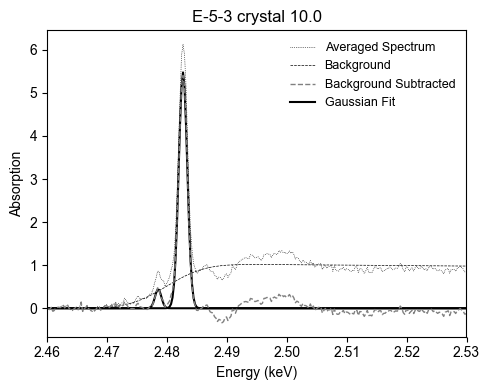

1.0


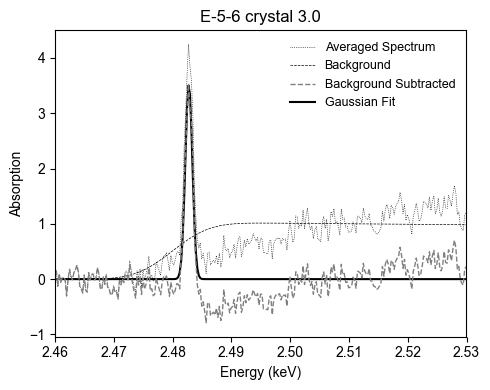

0.911456368168131


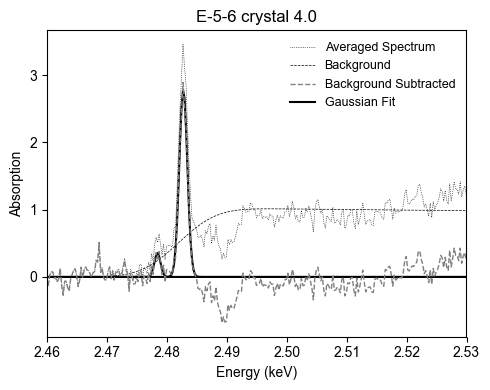

0.9132311214862662


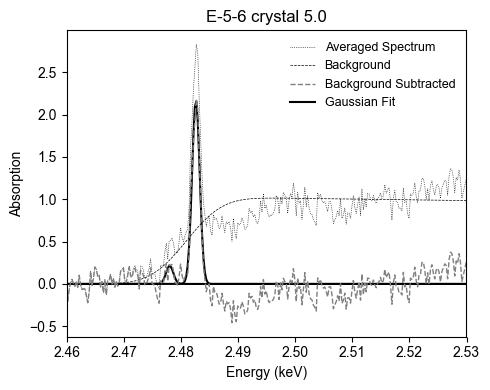

0.9362459694096693


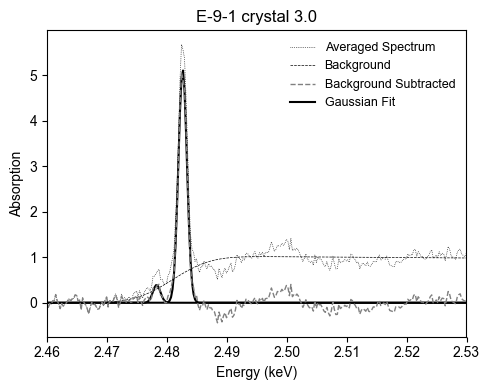

0.9479256445673911


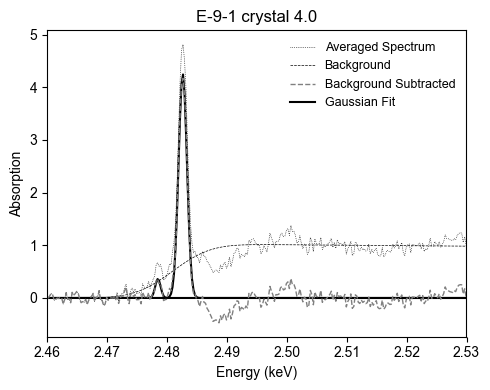

0.8728163492806794


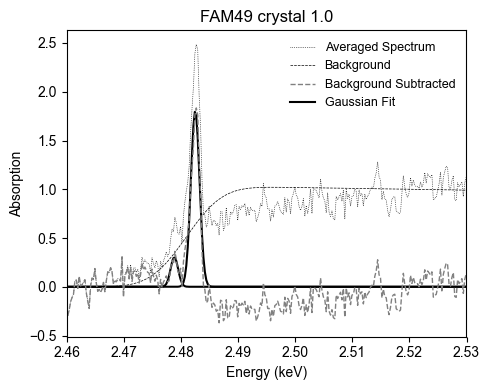

0.8469727326951287


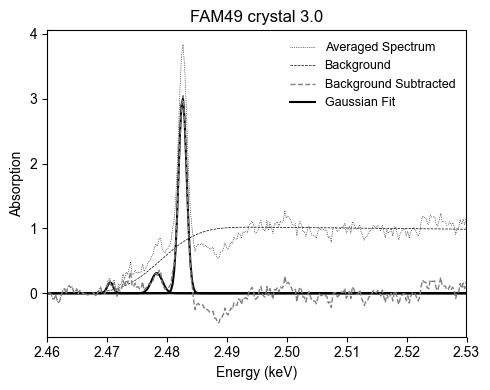

1.0


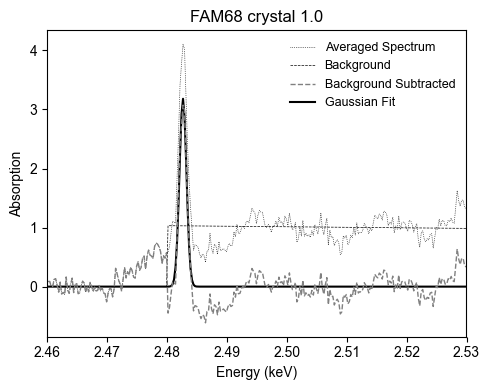

1.0


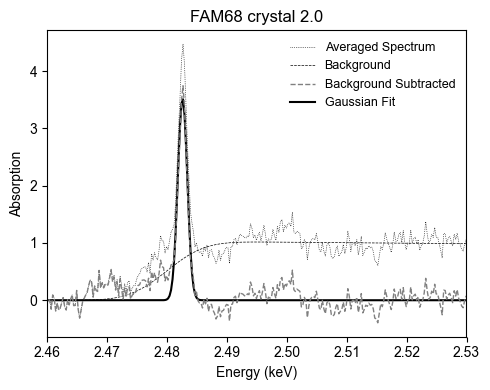

1.0


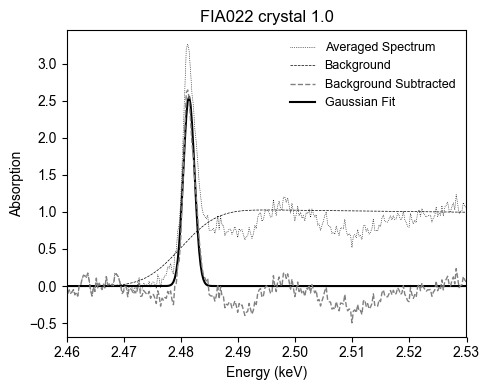

1.0


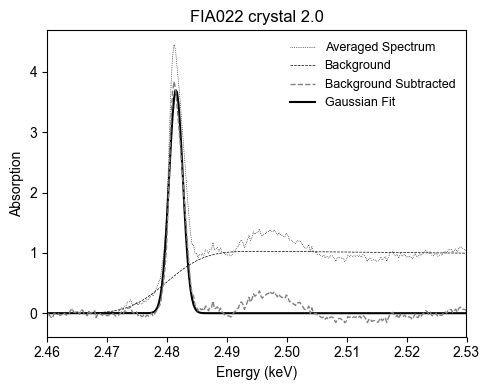

1.0


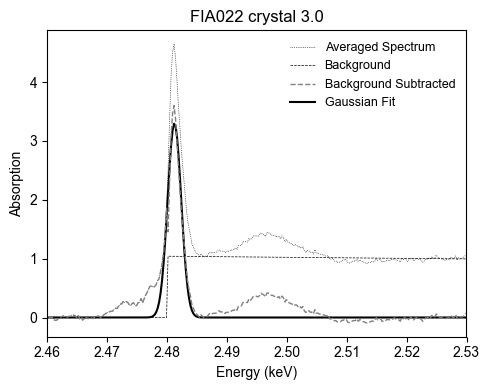

0.6330419956233834


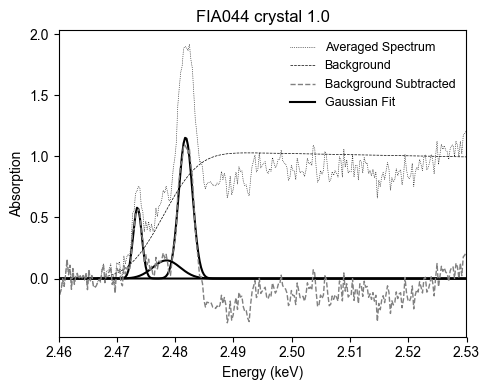

1.0


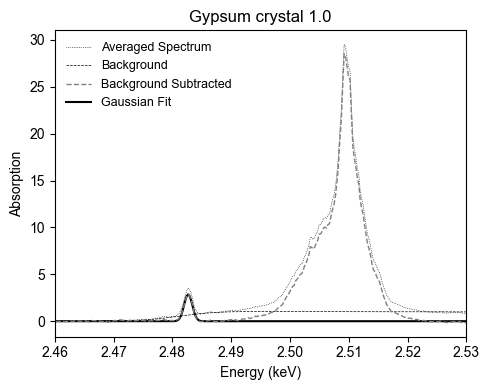

1.0


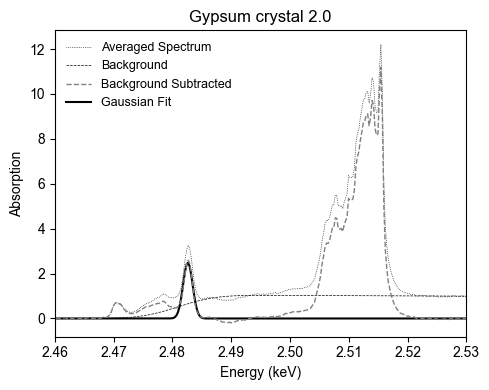

0.9766650199928473


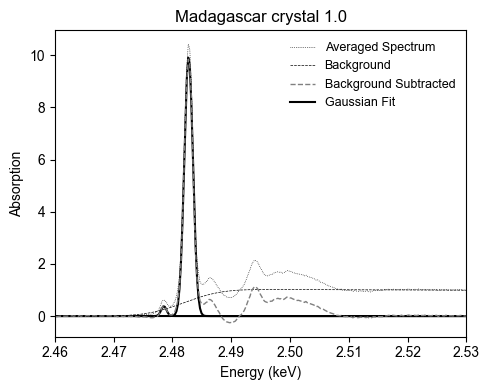

0


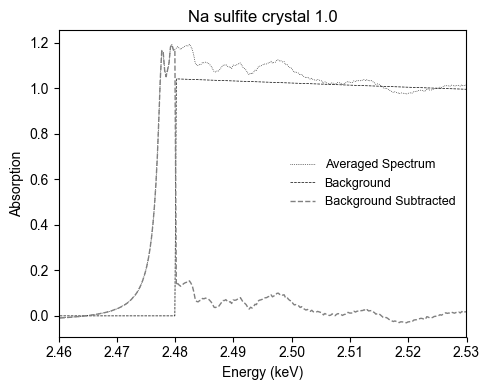

0


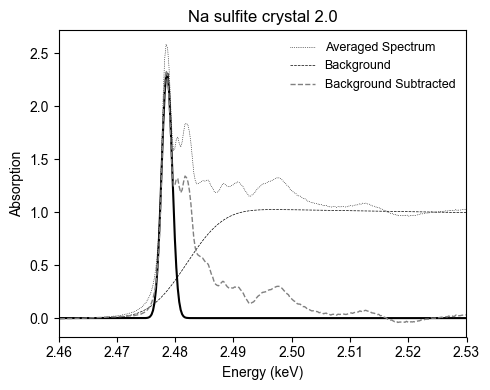

0.8679839595793736


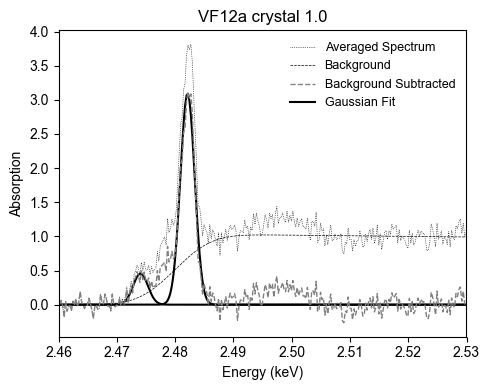

0.6758592778934585


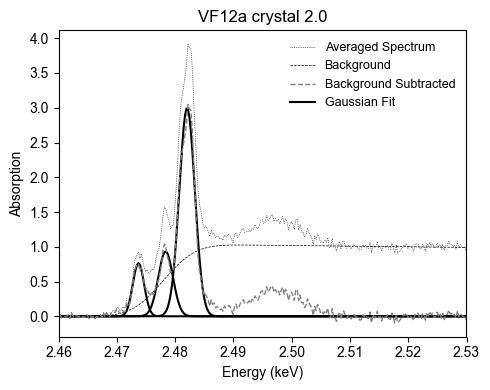

0.5301570604343129


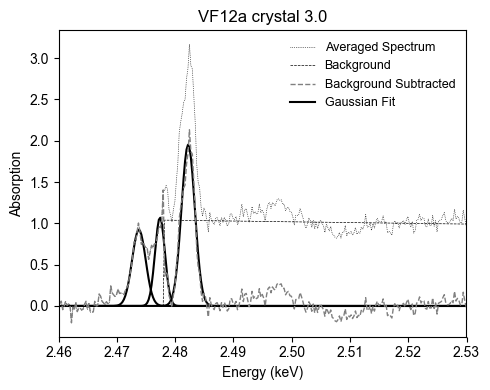

0.7332709944963884


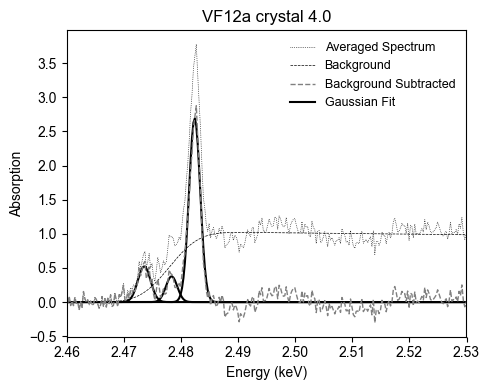

0.6469736810732567


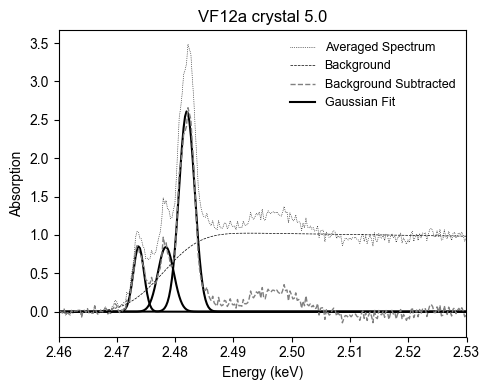

0.8033086656556749


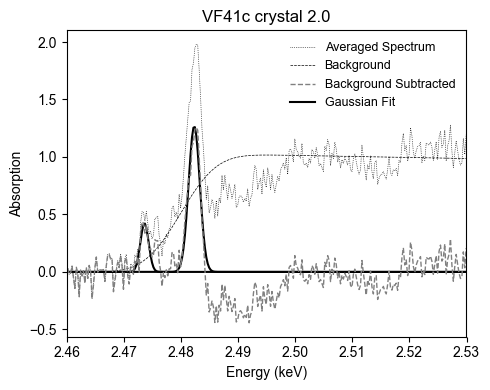

0.5045871329089741


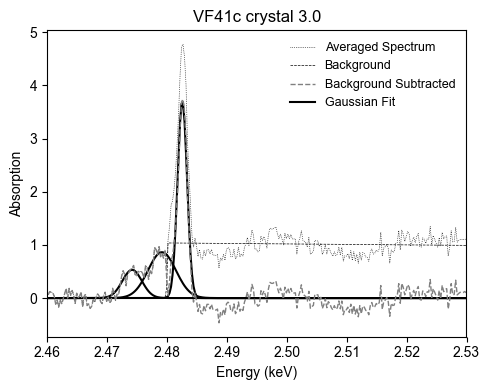

0.4702806606514813


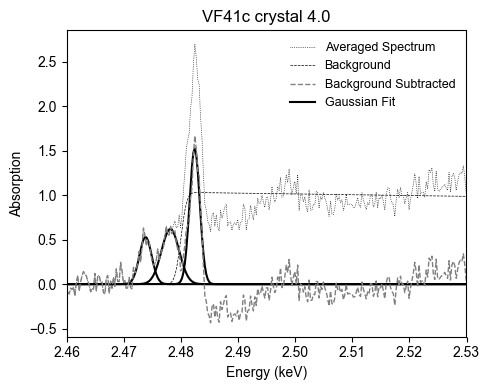

0.4728079289202087


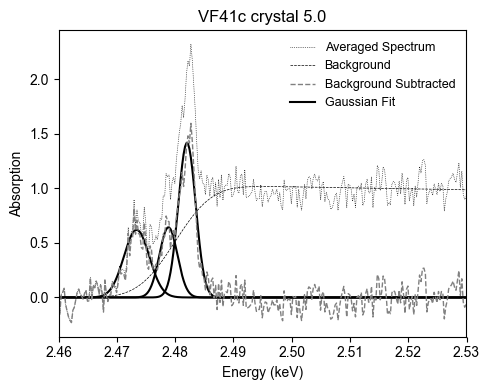

In [147]:
# MAKE A LOOP TO GO THROUGH ALL OF THE SPECTRA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import erfc
import matplotlib as mpl

# Set global font to Arial
mpl.rcParams['font.family'] = 'Arial'

# EMG function with fixed mu
def emg_unit(x, mu, sigma, lam):
    """Normalized EMG with asymptote from 0 to 1"""
    part1 = (lam / 2) * np.exp((lam / 2) * (2 * mu + lam * sigma**2 - 2 * x))
    part2 = erfc((mu + lam * sigma**2 - x) / (np.sqrt(2) * sigma))
    emg_raw = part1 * part2
    emg_min = np.min(emg_raw)
    emg_max = np.max(emg_raw)
    return (emg_raw - emg_min) / (emg_max - emg_min)

def emg_scaled(x, sigma, lam, A, baseline):
    return A * emg_unit(x, mu_fixed, sigma, lam) + baseline


# --- Load data ---
data = pd.read_csv('S_XANES_all_norm.csv')
energy = pd.to_numeric(data.columns, errors='coerce')[13:]
data = data[data['Discard'] != 'x'].reset_index(drop=True)
sample_groups = [data.groupby('Sample').get_group(x) for x in data.groupby('Sample').groups]

all_results = []

for sample in sample_groups:
    crystal_groups = [sample.groupby('Crystal').get_group(x) for x in sample.groupby('Crystal').groups]
    
    for crystal in crystal_groups:

        info = crystal.iloc[:, 0:-280]
        sample_name = crystal['Sample'].iloc[0]
        crystal_name = crystal['Crystal'].iloc[0]
        crystal = crystal.iloc[:, -280:]
        average = np.mean(crystal, axis = 0)
        
        # --- Fit background ---
        # NOTE: energy in keV, so we fix mu accordingly
        mu_fixed = info['Mu position'].iloc[0] # inflection point in keV
        
        # Select pre-edge and post-edge regions
        pre_edge = (energy < 2.468)
        post_edge = (energy > info['Postedge'].iloc[0])  # slightly increased range
        
        pre_edge_mean = np.mean(average[pre_edge])
        post_edge_mean = np.mean(average[post_edge])
        
        average = (average - pre_edge_mean) / (post_edge_mean - pre_edge_mean)
        
        background_x = np.concatenate((energy[pre_edge], energy[post_edge]))
        background_y = np.concatenate((average[pre_edge], average[post_edge]))
        
        # p0 = [0.0003, 20, max(background_y), min(background_y)]  # smaller sigma, bigger lam
        p0 = [0.0003, 1, max(background_y), min(background_y)]  # smaller sigma, bigger lam
        bounds = ([1e-6, 0.9, 0, -np.inf], [0.005, 1.1, np.inf, np.inf])
        
        # Fit
        popt, _ = curve_fit(emg_scaled, background_x, background_y, p0=p0, bounds=bounds, maxfev=10000)
        
        # Evaluate EMG background over full energy range
        emg_fit_full = emg_scaled(energy, *popt)
        
        # Optional normalization: force background to 0 at pre-edge, 1 at post-edge
        emg_pre = np.mean(emg_fit_full[pre_edge])
        emg_post = np.mean(emg_fit_full[post_edge])
        emg_fit_norm = (emg_fit_full - emg_pre) / (emg_post - emg_pre)
        
        # Subtract background
        y_corrected = average - emg_fit_norm
        
        # --- Plot ---
        plt.figure(figsize=(5,4))
        plt.plot(energy, average, label='Averaged Spectrum', color = 'black', linestyle = 'dotted', linewidth = 0.5)
        plt.plot(energy, emg_fit_norm, color = 'black', linestyle = '--', label='Background', linewidth = 0.5)
        plt.plot(energy, y_corrected, color = 'gray', linestyle = 'dashed', label='Background Subtracted', linewidth = 1)
        

            
        peak_dict = {}
        total_peak_area = 0
        s_peaks_present = info[['S2-', 'S-', 'S4+', 'S6+']].iloc[0]
    
        if s_peaks_present['S4+'] == 'x':
            try:
                y = y_corrected[s4_range_min:s4_range_max].values # interval for s6 to fit to
                popt,pcov = curve_fit(gaus,s4_x,y,p0=[1,s4mean,s4sigma]) # fit a gaussian curve
                s4curve = gaus(energy,*popt) # save fitted peak
                peak_dict['S4+'] = s4curve
                s4area = np.trapz(energy,gaus(energy,*popt)) # Calculate peak area ratio
                total_peak_area = total_peak_area + s4area
                plt.plot(energy,s4curve, color = 'black', zorder = 0.1)
            except:
                print('S4+ failed')
                pass # doing nothing on exception
        
        if s_peaks_present['S2-'] == 'x':
            try:
                y = y_corrected[s2_range_min:s2_range_max].values # interval for s6 to fit to    
                popt,pcov = curve_fit(gaus,s2_x,y,p0=[1,s2mean,s2sigma]) # fit a gaussian curve
                s2curve = gaus(energy,*popt) # save fitted peak
                peak_dict['S2-'] = s2curve
                s2area = np.trapz(energy,gaus(energy,*popt))
                total_peak_area = total_peak_area + s2area
                plt.plot(energy,s2curve, color = 'black', zorder = 0.1)
            except:
                print('S2- failed')
                pass
            
        if s_peaks_present['S-'] == 'x':
            try:
                y = y_corrected[s1_range_min:s1_range_max].values # interval for s6 to fit to    
                popt,pcov = curve_fit(gaus,s1_x,y,p0=[1,s1mean,s1sigma]) # fit a gaussian curve
                s1curve = gaus(energy,*popt) # save fitted peak
                peak_dict['S-'] = s1curve
                s1area = np.trapz(energy,gaus(energy,*popt))
                total_peak_area = total_peak_area + s1area
                plt.plot(energy,s1curve, color = 'black', zorder = 0.1)
            except:
                print('S- failed')
                pass
            
        if s_peaks_present['S6+'] == 'x':
            try:
                y = y_corrected[s6_range_min:s6_range_max].values # interval for s6 to fit to
                popt,pcov = curve_fit(gaus,s6_x,y,p0=[1,s6mean,s6sigma]) # fit a gaussian curve
                s6curve = gaus(energy,*popt)
                peak_dict['S6+'] = s6curve
                s6area = np.trapz(energy,gaus(energy,*popt))
                total_peak_area = total_peak_area + s6area
                peakratio = s6area/total_peak_area
                plt.plot(energy,s6curve, color = 'black', label = 'Gaussian Fit', zorder = 0.1)
            except:
                print('S6+ failed')
                peakratio = 0
                pass
            
        else:
            peakratio = 0

        print(peakratio)
        
        export = pd.concat([info.iloc[0,:], average, pd.Series(peakratio, name = 'S6/Stotal')], axis = 0)
        all_results.append(export)
        
        
        plt.title(sample_name + ' crystal ' + str(crystal_name))
        plt.legend(edgecolor = 'black', fontsize = 9, frameon=False)
        plt.xlabel('Energy (keV)')
        plt.ylabel('Absorption')
        plt.xlim([2.46, 2.53])
        plt.rcParams['svg.fonttype'] = 'none'
        plt.tight_layout()

        if sample_name + ' crystal ' + str(crystal_name) == 'E-1-7 crystal 12.0':
            plt.savefig('Fitting_Demo.svg', dpi = 1200)
        
        plt.show()
    

all_results = pd.DataFrame(all_results)
durango = all_results[all_results['Sample'] == 'Durango']
all_results = all_results[all_results['Sample'] != 'Gypsum']
all_results = all_results[all_results['Sample'] != 'Na sulfite']
# all_results = all_results[all_results['Sample'] != 'Durango']
# all_results = all_results[all_results['Sample'] != 'Madagascar']
all_results = all_results[all_results['Sample'] != 'FAM49']
all_results = all_results[all_results['Sample'] != 'FAM68']
all_results = all_results[all_results['Sample'] != 'FIA022']
all_results = all_results[all_results['Sample'] != 'FIA044']
all_results = all_results[all_results['Sample'] != 'VF12a']
all_results = all_results[all_results['Sample'] != 'VF41c']

all_results.to_csv('Processed_Averaged_XANES_Spectra_NoMC_BackgroundSubtracted.csv', index = False)

0 0.983931117703139


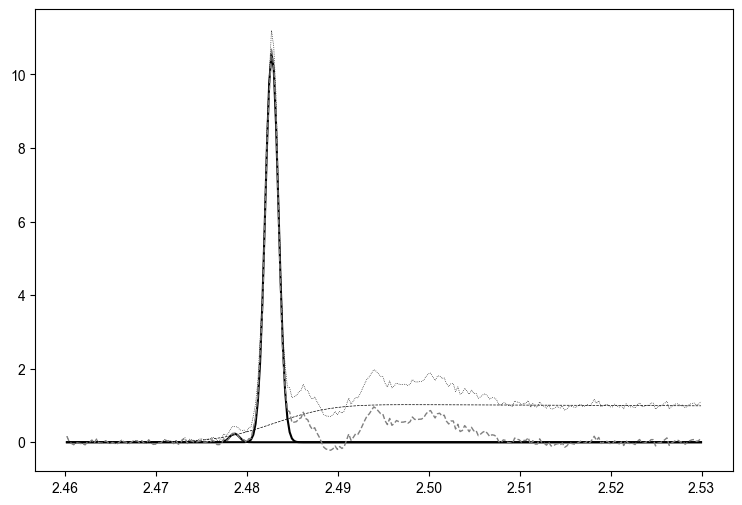

1 0.9719349049286192


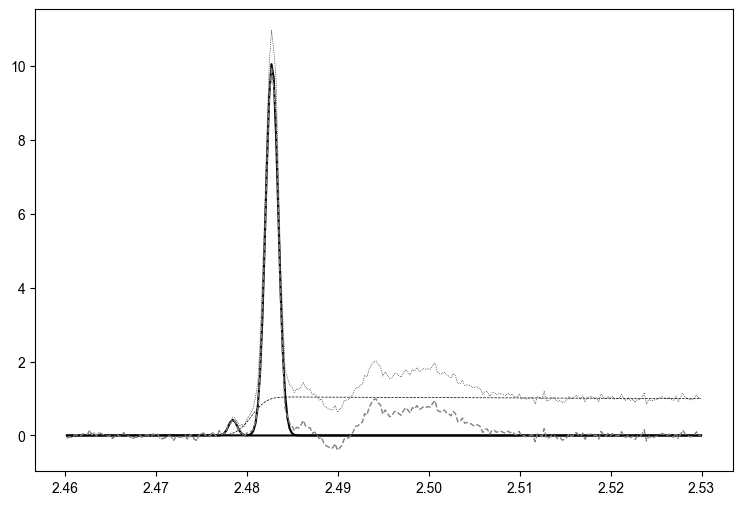

2 0.964465373652564


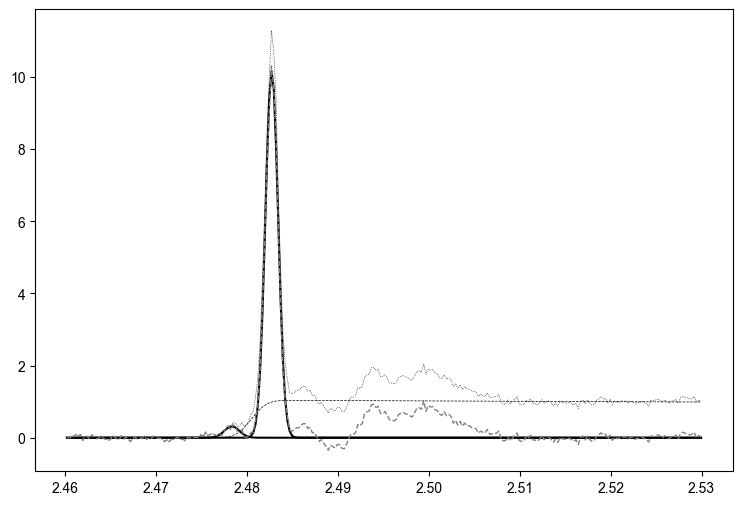

3 0.9784597755166001


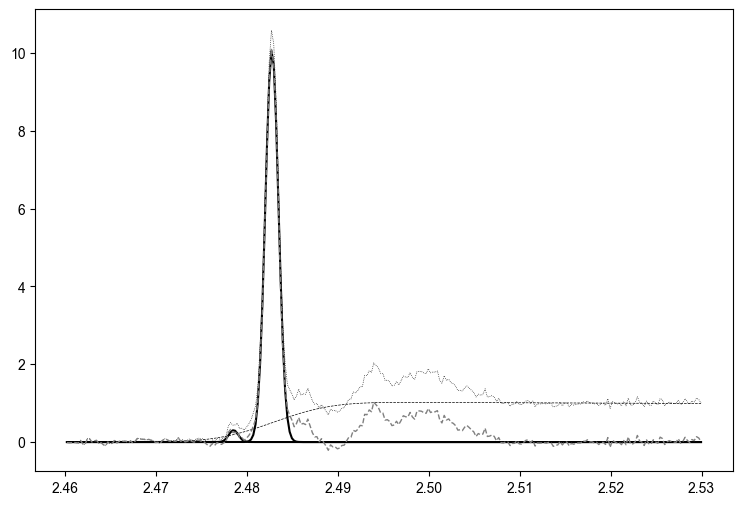

4 0.9806727426580643


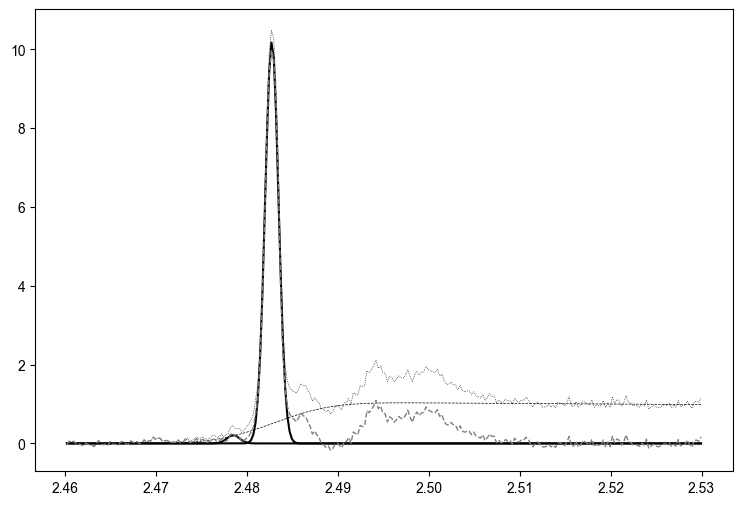

5 0.9829527907054444


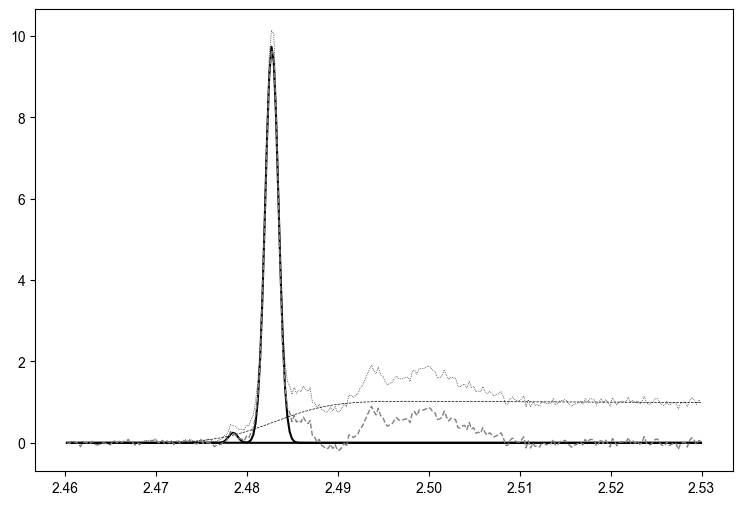

6 0.9784230475216528


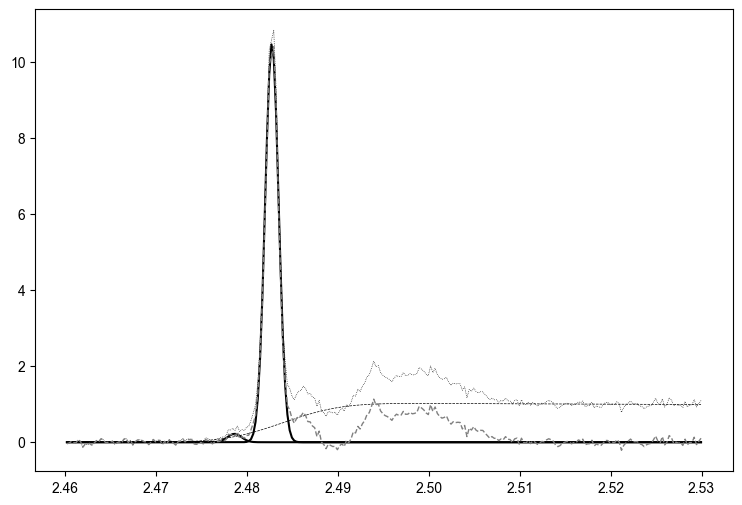

7 0.9468007939744577


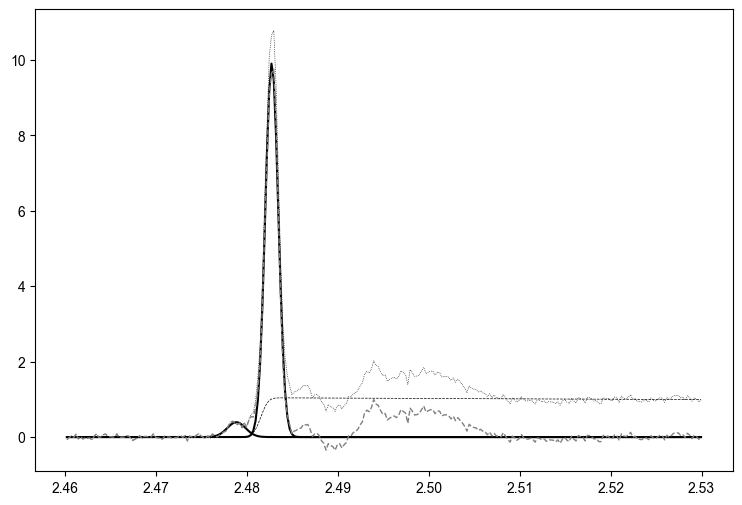

8 0.9308627204542091


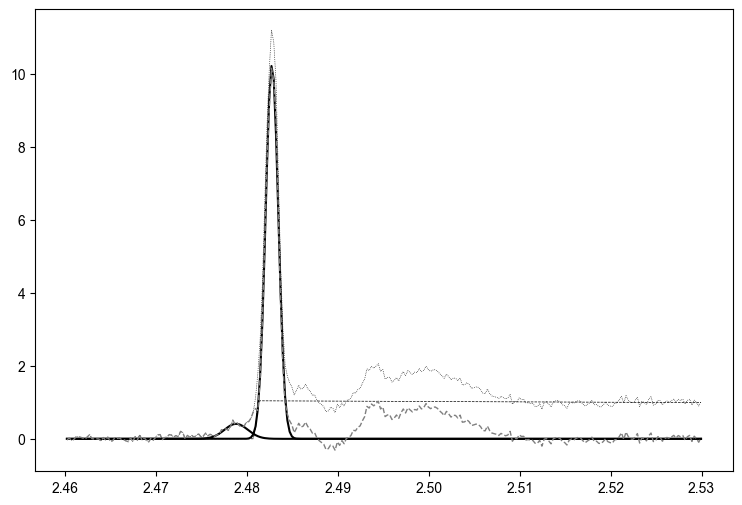

9 0.9782226019340925


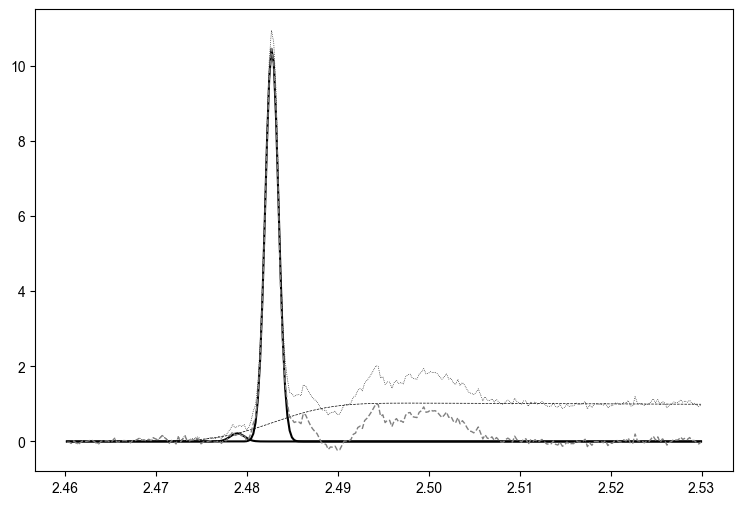

10 0.9220051285045207


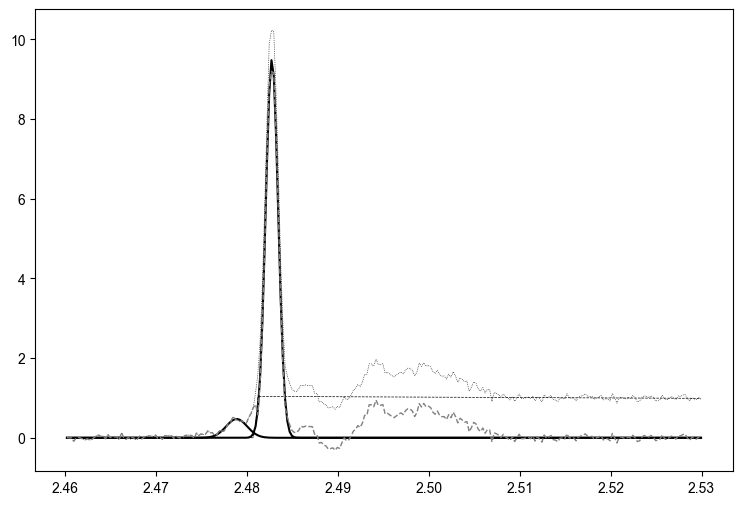

In [113]:
# Iterative fitting on Durango apatite

# Have to vary the parameters to get a good fit for all of them
mu_positions = [2.483, 2.4805, 2.4805, 2.483, 2.483, 2.483, 2.484, 2.4815, 2.481, 2.483, 2.481]
post_edges = [2.51, 2.52, 2.51, 2.51, 2.51, 2.51, 2.51, 2.515, 2.515, 2.51, 2.51]
all_peak_ratios = []
n = 0

for row, spectra in sample_groups[0].iterrows():
    info = spectra.iloc[0:-280]
    spectra = spectra.iloc[13:]

    # NOTE: energy in keV, so we fix mu accordingly
    mu_fixed = mu_positions[n] # inflection point in keV
    
    # Select pre-edge and post-edge regions
    pre_edge = (energy < 2.468)
    post_edge = (energy > post_edges[n])  # slightly increased range
    
    pre_edge_mean = np.mean(spectra[pre_edge])
    post_edge_mean = np.mean(spectra[post_edge])
    
    spectra = (spectra - pre_edge_mean) / (post_edge_mean - pre_edge_mean)
    
    background_x = np.concatenate((energy[pre_edge], energy[post_edge]))
    background_y = np.concatenate((spectra[pre_edge], spectra[post_edge]))
    
    p0 = [0.001, 5, 1, 0]  # smaller sigma, bigger lam
    bounds = ([0.0001, 1, 0, -np.inf], [0.005, 10, np.inf, np.inf])
    
    # Fit
    popt, _ = curve_fit(emg_scaled, background_x, background_y, p0=p0, bounds=bounds, maxfev=10000)
    
    # Evaluate EMG background over full energy range
    emg_fit_full = emg_scaled(energy, *popt)
    
    # Optional normalization: force background to 0 at pre-edge, 1 at post-edge
    emg_pre = np.mean(emg_fit_full[pre_edge])
    emg_post = np.mean(emg_fit_full[post_edge])
    emg_fit_norm = (emg_fit_full - emg_pre) / (emg_post - emg_pre)
    
    # Subtract background
    y_corrected = spectra - emg_fit_norm
    
    # --- Plot ---
    plt.figure(figsize=(9,6))
    plt.plot(energy, spectra, label='Durango Apatite', color = 'black', linestyle = 'dotted', linewidth = 0.5)
    plt.plot(energy, emg_fit_norm, color = 'black', linestyle = '--', label='Background', linewidth = 0.5)
    plt.plot(energy, y_corrected, color = 'gray', linestyle = 'dashed', label='Background Subtracted Durango', linewidth = 1)
    
    
        
    peak_dict = {}
    total_peak_area = 0
    s_peaks_present = info[['S2-', 'S-', 'S4+', 'S6+']]

    if s_peaks_present['S4+'] == 'x':
        try:
            y = y_corrected[s4_range_min:s4_range_max].values # interval for s6 to fit to
            popt,pcov = curve_fit(gaus,s4_x,y,p0=[1,s4mean,s4sigma]) # fit a gaussian curve
            s4curve = gaus(energy,*popt) # save fitted peak
            peak_dict['S4+'] = s4curve
            s4area = np.trapz(energy,gaus(energy,*popt)) # Calculate peak area ratio
            total_peak_area = total_peak_area + s4area
            plt.plot(energy,s4curve, color = 'black', label = 'Gaussian fits', zorder = 0.1)
        except:
            print('S4+ failed')
            pass # doing nothing on exception
    
    if s_peaks_present['S2-'] == 'x':
        try:
            y = y_corrected[s2_range_min:s2_range_max].values # interval for s6 to fit to    
            popt,pcov = curve_fit(gaus,s2_x,y,p0=[1,s2mean,s2sigma]) # fit a gaussian curve
            s2curve = gaus(energy,*popt) # save fitted peak
            peak_dict['S2-'] = s2curve
            s2area = np.trapz(energy,gaus(energy,*popt))
            total_peak_area = total_peak_area + s2area
            plt.plot(energy,s2curve, color = 'black', label = 'Gaussian fits', zorder = 0.1)
        except:
            print('S2- failed')
            pass
        
    if s_peaks_present['S-'] == 'x':
        try:
            y = y_corrected[s1_range_min:s1_range_max].values # interval for s6 to fit to    
            popt,pcov = curve_fit(gaus,s1_x,y,p0=[1,s1mean,s1sigma]) # fit a gaussian curve
            s1curve = gaus(energy,*popt) # save fitted peak
            peak_dict['S-'] = s1curve
            s1area = np.trapz(energy,gaus(energy,*popt))
            total_peak_area = total_peak_area + s1area
            plt.plot(energy,s1curve, color = 'black', label = 'Gaussian fits', zorder = 0.1)
        except:
            print('S- failed')
            pass
        
    if s_peaks_present['S6+'] == 'x':
        try:
            y = y_corrected[s6_range_min:s6_range_max].values # interval for s6 to fit to
            popt,pcov = curve_fit(gaus,s6_x,y,p0=[1,s6mean,s6sigma]) # fit a gaussian curve
            s6curve = gaus(energy,*popt)
            peak_dict['S6+'] = s6curve
            s6area = np.trapz(energy,gaus(energy,*popt))
            total_peak_area = total_peak_area + s6area
            peakratio = s6area/total_peak_area
            plt.plot(energy,s6curve, color = 'black', label = 'Gaussian fits', zorder = 0.1)
        except:
            print('S6+ failed')
            peakratio = 0
            pass
        
    else:
        peakratio = 0
    print(n, peakratio)
    all_peak_ratios.append(peakratio)
    n = n + 1

    plt.show()

In [124]:
all_peak_ratios, np.mean(all_peak_ratios), np.std(all_peak_ratios)



([0.9875425174045527,
  0.9767258606439125,
  0.9659259562130063,
  0.9817686140185348,
  0.9859641163235918,
  0.9866236265679474,
  0.981784953041616,
  0.9675559217609293,
  0.9625034418407404,
  0.9830018995190722,
  0.9596619212672073],
 0.9762780753273735,
 0.009921047200628854)